In [1]:
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from tqdm import tqdm
from obspy.geodetics import locations2degrees, degrees2kilometers

## Morton Catalog

In [2]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2012-10-01 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2012-10-31 23:59:59.999999+0000', tz='UTC')

events_morton_201210= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton_201210.head()

CI YEAR       TSTRING    YEAR  MONTH  DAY  HOUR  MINUTE  SECOND      LAT  \
630      2.0  2.012100e+13  2012.0   10.0  1.0   4.0    32.0   57.05  40.7190   
631      2.0  2.012100e+13  2012.0   10.0  1.0  23.0    30.0   58.38  40.5787   
632      2.0  2.012100e+13  2012.0   10.0  2.0   4.0    25.0   46.37  40.5592   
633      2.0  2.012100e+13  2012.0   10.0  2.0   5.0    16.0   28.35  40.5075   
634      2.0  2.012100e+13  2012.0   10.0  2.0   6.0    17.0   18.88  40.4213   

          LON  ...  dist to nearest stn  tt RMS  ERH   ERZ  STRIKE    DIP  \
630 -125.9525  ...                 34.0    0.46  2.6  29.2     NaN    NaN   
631 -124.8887  ...                 11.8    0.34  6.9   5.8     NaN    NaN   
632 -125.2087  ...                 24.1    0.30  1.7   5.0     NaN    NaN   
633 -124.5450  ...                  7.3    0.35  1.1   1.2     NaN    NaN   
634 -125.3963  ...                 31.2    0.46  1.4  34.8  316.59  43.54   

      RAKE  PLATE DESIGNATION  TEMPLATE EVENT?                  datetime  
630    NaN  Seaward of Trench              NaN 2012-10-01 04:32:57+00:00  
631    NaN               Slab              NaN 2012-10-01 23:30:58+00:00  
632    NaN  Seaward of Trench              NaN 2012-10-02 04:25:46+00:00  
633    NaN               Slab              NaN 2012-10-02 05:16:28+00:00  
634 -85.95  Seaward of Trench              NaN 2012-10-02 06:17:18+00:00  

[5 rows x 24 columns]

In [3]:
events_morton['datetime'].max()

Timestamp('2015-10-07 21:45:50+0000', tz='UTC')

In [4]:
events_morton_201210.keys()

Index(['CI YEAR', 'TSTRING', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE',
       'SECOND', 'LAT', 'LON', 'DEPTH', 'Md', 'Num P&S with weights > 0.1',
       'max az gap', 'dist to nearest stn', 'tt RMS', 'ERH', 'ERZ', 'STRIKE',
       'DIP', 'RAKE', 'PLATE DESIGNATION', 'TEMPLATE EVENT?', 'datetime'],
      dtype='object')

In [5]:
len(events_morton_201210)

91

## ANSS Catalog

In [6]:
events_anss_201210 = pd.read_csv('../data/anss_201210.csv')
events_anss_201210['datetime'] = pd.to_datetime(events_anss_201210['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
events_anss_201210

time   latitude   longitude   depth   mag magType  \
0   2012-10-31T15:29:52.780Z  40.973667 -123.699667  11.475  3.21      mw   
1   2012-10-31T13:00:15.010Z  41.798000 -127.048000  10.000  4.20      mb   
2   2012-10-31T08:38:35.050Z  39.365833 -123.224667   6.059  1.57      md   
3   2012-10-29T18:30:35.180Z  49.167000 -127.778000  10.000  4.40      mb   
4   2012-10-29T03:56:54.290Z  39.579500 -123.506333   3.504  1.19      md   
..                       ...        ...         ...     ...   ...     ...   
88  2012-10-03T01:14:36.140Z  40.387000 -124.275000  23.379  2.08      md   
89  2012-10-02T21:45:36.820Z  40.270333 -124.481000  18.320  1.15      md   
90  2012-10-02T18:10:46.480Z  45.017000 -126.764000  10.000  2.70      md   
91  2012-10-02T02:56:59.840Z  40.328833 -125.431500   5.982  2.78      md   
92  2012-10-02T02:37:36.170Z  40.324333 -125.393500   0.908  2.79      md   

    nst    gap     dmin   rms  ...                                   place  \
0    18   83.0  0.10180  0.18  ...    6 km WNW of Willow Creek, California   
1    43  209.0      NaN  0.99  ...      226 km WSW of Pistol River, Oregon   
2    14   67.0  0.17120  0.05  ...  10 km WNW of Potter Valley, California   
3    16  181.5      NaN  1.33  ...              136 km W of Tofino, Canada   
4     3  172.0  0.08649  0.18  ...      12 km S of Laytonville, California   
..  ...    ...      ...   ...  ...                                     ...   
88   16  145.0  0.06577  0.09  ...          18 km SW of Scotia, California   
89    8  303.0  0.15860  0.16  ...       38 km SSW of Ferndale, California   
90   13  269.4      NaN  1.19  ...           214 km W of Depoe Bay, Oregon   
91   24  302.0  0.84770  0.38  ...      102 km WSW of Ferndale, California   
92   49  280.0  0.81980  0.47  ...       99 km WSW of Ferndale, California   

          type horizontalError depthError magError  magNst    status  \
0   earthquake            0.31       0.41      NaN     3.0  reviewed   
1   earthquake             NaN        NaN      NaN     4.0  reviewed   
2   earthquake            0.22       1.52    0.276    16.0  reviewed   
3   earthquake             NaN        NaN      NaN     3.0  reviewed   
4   earthquake            6.63      14.38    0.229     3.0  reviewed   
..         ...             ...        ...      ...     ...       ...   
88  earthquake            0.79       0.69    0.262    22.0  reviewed   
89  earthquake            1.11       1.02    0.214     4.0  reviewed   
90  earthquake             NaN        NaN      NaN     NaN  reviewed   
91  earthquake           13.20      11.72    0.099    33.0  reviewed   
92  earthquake           10.72       6.13    0.154    41.0  reviewed   

    locationSource  magSource                         datetime  
0               nc         nc 2012-10-31 15:29:52.780000+00:00  
1               us         us 2012-10-31 13:00:15.010000+00:00  
2               nc         nc 2012-10-31 08:38:35.050000+00:00  
3               us         us 2012-10-29 18:30:35.180000+00:00  
4               nc         nc 2012-10-29 03:56:54.290000+00:00  
..             ...        ...                              ...  
88              nc         nc 2012-10-03 01:14:36.140000+00:00  
89              nc         nc 2012-10-02 21:45:36.820000+00:00  
90              us        sea 2012-10-02 18:10:46.480000+00:00  
91              nc         nc 2012-10-02 02:56:59.840000+00:00  
92              nc         nc 2012-10-02 02:37:36.170000+00:00  

[93 rows x 23 columns]

In [7]:
events_anss_201210

time   latitude   longitude   depth   mag magType  \
0   2012-10-31T15:29:52.780Z  40.973667 -123.699667  11.475  3.21      mw   
1   2012-10-31T13:00:15.010Z  41.798000 -127.048000  10.000  4.20      mb   
2   2012-10-31T08:38:35.050Z  39.365833 -123.224667   6.059  1.57      md   
3   2012-10-29T18:30:35.180Z  49.167000 -127.778000  10.000  4.40      mb   
4   2012-10-29T03:56:54.290Z  39.579500 -123.506333   3.504  1.19      md   
..                       ...        ...         ...     ...   ...     ...   
88  2012-10-03T01:14:36.140Z  40.387000 -124.275000  23.379  2.08      md   
89  2012-10-02T21:45:36.820Z  40.270333 -124.481000  18.320  1.15      md   
90  2012-10-02T18:10:46.480Z  45.017000 -126.764000  10.000  2.70      md   
91  2012-10-02T02:56:59.840Z  40.328833 -125.431500   5.982  2.78      md   
92  2012-10-02T02:37:36.170Z  40.324333 -125.393500   0.908  2.79      md   

    nst    gap     dmin   rms  ...                                   place  \
0    18   83.0  0.10180  0.18  ...    6 km WNW of Willow Creek, California   
1    43  209.0      NaN  0.99  ...      226 km WSW of Pistol River, Oregon   
2    14   67.0  0.17120  0.05  ...  10 km WNW of Potter Valley, California   
3    16  181.5      NaN  1.33  ...              136 km W of Tofino, Canada   
4     3  172.0  0.08649  0.18  ...      12 km S of Laytonville, California   
..  ...    ...      ...   ...  ...                                     ...   
88   16  145.0  0.06577  0.09  ...          18 km SW of Scotia, California   
89    8  303.0  0.15860  0.16  ...       38 km SSW of Ferndale, California   
90   13  269.4      NaN  1.19  ...           214 km W of Depoe Bay, Oregon   
91   24  302.0  0.84770  0.38  ...      102 km WSW of Ferndale, California   
92   49  280.0  0.81980  0.47  ...       99 km WSW of Ferndale, California   

          type horizontalError depthError magError  magNst    status  \
0   earthquake            0.31       0.41      NaN     3.0  reviewed   
1   earthquake             NaN        NaN      NaN     4.0  reviewed   
2   earthquake            0.22       1.52    0.276    16.0  reviewed   
3   earthquake             NaN        NaN      NaN     3.0  reviewed   
4   earthquake            6.63      14.38    0.229     3.0  reviewed   
..         ...             ...        ...      ...     ...       ...   
88  earthquake            0.79       0.69    0.262    22.0  reviewed   
89  earthquake            1.11       1.02    0.214     4.0  reviewed   
90  earthquake             NaN        NaN      NaN     NaN  reviewed   
91  earthquake           13.20      11.72    0.099    33.0  reviewed   
92  earthquake           10.72       6.13    0.154    41.0  reviewed   

    locationSource  magSource                         datetime  
0               nc         nc 2012-10-31 15:29:52.780000+00:00  
1               us         us 2012-10-31 13:00:15.010000+00:00  
2               nc         nc 2012-10-31 08:38:35.050000+00:00  
3               us         us 2012-10-29 18:30:35.180000+00:00  
4               nc         nc 2012-10-29 03:56:54.290000+00:00  
..             ...        ...                              ...  
88              nc         nc 2012-10-03 01:14:36.140000+00:00  
89              nc         nc 2012-10-02 21:45:36.820000+00:00  
90              us        sea 2012-10-02 18:10:46.480000+00:00  
91              nc         nc 2012-10-02 02:56:59.840000+00:00  
92              nc         nc 2012-10-02 02:37:36.170000+00:00  

[93 rows x 23 columns]

## Our Catalog

In [8]:
# Load all the pick assignments 
mycatalog_picks = pd.read_csv('../data/all_pick_assignments_201210.csv')
mycatalog = mycatalog_picks.drop_duplicates(subset=['idx'])
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
mycatalog=mycatalog.loc[(mycatalog['datetime'] > t1) & (mycatalog['datetime'] < t2) ]
mycatalog.head()

/tmp/ipykernel_695744/778102704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)


Unnamed: 0  idx                              time           x           y  \
0            0    0  2012-10-01 04:32:56.834786+00:00  -36.801756 -416.426130   
21          21    1  2012-10-01 06:06:25.601846+00:00  104.483147 -425.999093   
30          30    2  2012-10-01 06:49:32.006296+00:00   62.182278 -443.948400   
46          46    3  2012-10-01 06:55:58.805940+00:00   79.102626 -479.847012   
56          56    4  2012-10-01 07:27:43.834659+00:00   74.026521 -458.307844   

            z  picks   latitude   longitude      depth  event_idx  pick_idx  \
0   37.890625     21  40.750478 -125.935772  37.890625          0    153772   
21  25.390625      9  40.658485 -124.264521  25.390625          1    554952   
30  33.984375     16  40.501128 -124.766430  33.984375          2     86563   
46  27.734375     10  40.176440 -124.571285  27.734375          3    153785   
56  36.328125     23  40.370857 -124.628388  36.328125          4    153787   

    residual station phase     time_pick                         datetime  
0   0.891797   FS01B     P  1.349066e+09 2012-10-01 04:32:56.834786+00:00  
21 -0.426542   FS04B     S  1.349072e+09 2012-10-01 06:06:25.601846+00:00  
30  0.851777   BB030     P  1.349074e+09 2012-10-01 06:49:32.006296+00:00  
46 -0.829479   FS01B     P  1.349075e+09 2012-10-01 06:55:58.805940+00:00  
56 -0.192129   FS01B     P  1.349076e+09 2012-10-01 07:27:43.834659+00:00

In [9]:
len(mycatalog)

1039

## Run this loop

In [10]:
matched_events_mycatalog2morton = []
matched_times_morton2mycatalog = []
matched_events_morton2mycatalog = []
unmatched_times_morton2mycatalog = []
unmatched_events_morton2mycatalog = []
unmatched_events_mycatalog2morton_and_anss = []
matched_events_anss2mycatalog=[]
matched_events_mycatalog2anss = []
unmatched_times_anss2mycatalog = []
unmatched_events_anss2mycatalog = []

time_threshold = 5

lat_morton = []
lon_morton = []

# A set to keep track of matched indices in mycatalog
matched_indices_morton = set()
matched_indices_anss = set()

# Loop over events in Morton's catalog
for i in range(len(events_morton_201210)):
    t11 = events_morton_201210.iloc[i]['datetime']
    time_condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                     (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold))
    matched_df = mycatalog.loc[time_condition]

    if len(matched_df) == 1:
        matched_times_morton2mycatalog.append(t11)
        matched_events_morton2mycatalog.append(events_morton_201210.iloc[i])
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog2morton.append(matched_df)
        matched_indices_morton.update(matched_df['idx'])
    elif len(matched_df) > 1:
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_times_morton2mycatalog.append(t11)
        matched_events_morton2mycatalog.append(events_morton_201210.iloc[i])
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog2morton.append(closest_event)
        matched_indices_morton.update(closest_event['idx'])
    else:
        unmatched_times_morton2mycatalog.append(t11)
        unmatched_events_morton2mycatalog.append(events_morton_201210.iloc[i])

# All events in mycatalog not matched with Morton's catalog are unmatched
unmatched_indices_morton = set(mycatalog.idx) - matched_indices_morton
# unmatched_events_mycatalog2morton = mycatalog.iloc[list(unmatched_indices_morton)]

# Loop over events in ANSS catalog
for i in range(len(events_anss_201210)):
    t11 = events_anss_201210.iloc[i]['datetime']
    time_condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                     (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold))
    matched_df = mycatalog.loc[time_condition]

    if len(matched_df) == 1:
        matched_events_anss2mycatalog.append(events_anss_201210.iloc[i])
        
        matched_events_mycatalog2anss.append(matched_df)
        matched_indices_anss.update(matched_df['idx'])
        
    elif len(matched_df) > 1:
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_events_anss2mycatalog.append(events_anss_201210.iloc[i])
        
        matched_events_mycatalog2anss.append(closest_event)
        matched_indices_anss.update(closest_event['idx'])
        
    else:
        unmatched_times_anss2mycatalog.append(t11)
        unmatched_events_anss2mycatalog.append(events_anss_201210.iloc[i])

# All events in mycatalog not matched with ANSS catalog are unmatched
unmatched_indices_anss = set(mycatalog.idx) - matched_indices_anss
print(len(unmatched_indices_morton))
print(len(unmatched_indices_anss))

unmatched_indices_morton_and_anss = unmatched_indices_morton.intersection(unmatched_indices_anss)
print(len(unmatched_indices_morton_and_anss))
unmatched_events_mycatalog2morton_and_anss = mycatalog.iloc[list(unmatched_indices_morton_and_anss)]

951
969
903


In [11]:
# new concat code
# Concatenate and clean up dataframes
if len(matched_events_mycatalog2morton)>0:
    matched_events_mycatalog2morton = pd.concat(matched_events_mycatalog2morton).drop_duplicates(subset=['datetime']).reset_index(drop=True)
    matched_times_mycatalog2morton = matched_events_mycatalog2morton['datetime']
    lat_mycatalog = matched_events_mycatalog2morton['latitude']
    lon_mycatalog = matched_events_mycatalog2morton['longitude']


if len(unmatched_events_morton2mycatalog)>0:
    unmatched_events_morton2mycatalog = pd.DataFrame(unmatched_events_morton2mycatalog).reset_index(drop=True)

if len(unmatched_events_mycatalog2morton_and_anss) > 0:
    unmatched_events_mycatalog2morton_and_anss = unmatched_events_mycatalog2morton_and_anss.drop_duplicates(subset=['datetime']).reset_index(drop=True)

if len(matched_events_mycatalog2anss)>0:
    matched_events_mycatalog2anss = pd.concat(matched_events_mycatalog2anss).drop_duplicates(subset=['datetime']).reset_index(drop=True)

if len(unmatched_events_anss2mycatalog)>0:
    unmatched_events_anss2mycatalog = pd.DataFrame(unmatched_events_anss2mycatalog).drop_duplicates(subset=['datetime']).reset_index(drop=True)

if len(matched_events_morton2mycatalog)>0:   
    matched_events_morton2mycatalog = pd.DataFrame(matched_events_morton2mycatalog).reset_index(drop=True)
    
if len(matched_events_anss2mycatalog)>0:   
    matched_events_anss2mycatalog = pd.DataFrame(matched_events_anss2mycatalog).reset_index(drop=True)

In [12]:
matched_indices_morton_and_anss = matched_indices_morton.intersection(matched_indices_anss)
len(matched_indices_morton_and_anss)

22

In [13]:
matched_events_anss2mycatalog

time   latitude   longitude   depth   mag magType  \
0   2012-10-31T15:29:52.780Z  40.973667 -123.699667  11.475  3.21      mw   
1   2012-10-31T13:00:15.010Z  41.798000 -127.048000  10.000  4.20      mb   
2   2012-10-29T18:30:35.180Z  49.167000 -127.778000  10.000  4.40      mb   
3   2012-10-28T01:12:46.630Z  40.604500 -125.013000   1.049  2.26      md   
4   2012-10-27T17:10:47.440Z  40.406500 -124.358833  20.390  1.13      md   
..                       ...        ...         ...     ...   ...     ...   
65  2012-10-04T05:07:26.180Z  44.606333 -124.476333   8.036  2.06      md   
66  2012-10-03T01:14:36.140Z  40.387000 -124.275000  23.379  2.08      md   
67  2012-10-02T21:45:36.820Z  40.270333 -124.481000  18.320  1.15      md   
68  2012-10-02T02:56:59.840Z  40.328833 -125.431500   5.982  2.78      md   
69  2012-10-02T02:37:36.170Z  40.324333 -125.393500   0.908  2.79      md   

    nst    gap     dmin   rms  ...                                 place  \
0    18   83.0  0.10180  0.18  ...  6 km WNW of Willow Creek, California   
1    43  209.0      NaN  0.99  ...    226 km WSW of Pistol River, Oregon   
2    16  181.5      NaN  1.33  ...            136 km W of Tofino, Canada   
3    26  286.0  0.53060  0.46  ...       63 km W of Ferndale, California   
4     9  289.0  0.10180  0.13  ...     20 km SSW of Ferndale, California   
..  ...    ...      ...   ...  ...                                   ...   
65   15  241.0  0.30770  0.42  ...              near the coast of Oregon   
66   16  145.0  0.06577  0.09  ...        18 km SW of Scotia, California   
67    8  303.0  0.15860  0.16  ...     38 km SSW of Ferndale, California   
68   24  302.0  0.84770  0.38  ...    102 km WSW of Ferndale, California   
69   49  280.0  0.81980  0.47  ...     99 km WSW of Ferndale, California   

          type horizontalError depthError magError  magNst    status  \
0   earthquake            0.31       0.41      NaN     3.0  reviewed   
1   earthquake             NaN        NaN      NaN     4.0  reviewed   
2   earthquake             NaN        NaN      NaN     3.0  reviewed   
3   earthquake            5.55       8.40    0.116    15.0  reviewed   
4   earthquake            1.53       0.55    0.258     3.0  reviewed   
..         ...             ...        ...      ...     ...       ...   
65  earthquake            1.52      35.97    0.279     9.0  reviewed   
66  earthquake            0.79       0.69    0.262    22.0  reviewed   
67  earthquake            1.11       1.02    0.214     4.0  reviewed   
68  earthquake           13.20      11.72    0.099    33.0  reviewed   
69  earthquake           10.72       6.13    0.154    41.0  reviewed   

    locationSource  magSource                         datetime  
0               nc         nc 2012-10-31 15:29:52.780000+00:00  
1               us         us 2012-10-31 13:00:15.010000+00:00  
2               us         us 2012-10-29 18:30:35.180000+00:00  
3               nc         nc 2012-10-28 01:12:46.630000+00:00  
4               nc         nc 2012-10-27 17:10:47.440000+00:00  
..             ...        ...                              ...  
65              uw         uw 2012-10-04 05:07:26.180000+00:00  
66              nc         nc 2012-10-03 01:14:36.140000+00:00  
67              nc         nc 2012-10-02 21:45:36.820000+00:00  
68              nc         nc 2012-10-02 02:56:59.840000+00:00  
69              nc         nc 2012-10-02 02:37:36.170000+00:00  

[70 rows x 23 columns]

In [14]:
matched_events_mycatalog2morton

Unnamed: 0   idx                              time           x  \
0            0     0  2012-10-01 04:32:56.834786+00:00  -36.801756   
1          271    16  2012-10-01 23:30:57.202589+00:00   59.644226   
2          514    24  2012-10-02 04:25:45.218111+00:00   28.341582   
3          594    26  2012-10-02 05:16:27.257156+00:00   80.794660   
4          645    27  2012-10-02 06:17:18.197502+00:00    8.037165   
..         ...   ...                               ...         ...   
83       14825   936  2012-10-28 02:41:20.201347+00:00   36.801756   
84       15434   978  2012-10-30 01:39:09.445605+00:00  121.403495   
85       15973  1013  2012-10-31 04:38:08.779493+00:00   25.803530   
86       16149  1026  2012-10-31 15:29:52.919409+00:00  136.631808   
87       16188  1027  2012-10-31 16:13:42.118762+00:00   73.180504   

             y          z  picks   latitude   longitude      depth  event_idx  \
0  -416.426130  37.890625     21  40.750478 -125.935772  37.890625          0   
1  -431.982195  37.890625     26  40.609066 -124.795241  37.890625         16   
2  -428.392334  41.015625     50  40.643057 -125.164944  41.015625         24   
3  -434.375436  46.484375     51  40.585722 -124.545662  46.484375         26   
4  -449.931502  39.453125     35  40.449537 -125.405257  39.453125         27   
..         ...        ...    ...        ...         ...        ...        ...   
83 -457.111224  21.484375     11  40.384106 -125.066598  21.484375        936   
84 -397.280203  33.984375     25  40.914702 -124.058921  33.984375        978   
85 -452.324742  17.578125     14  40.427623 -125.195924  17.578125       1013   
86 -385.313999  49.609375     39  41.020011 -123.875584  49.609375       1026   
87 -430.785575  46.484375     28  40.618754 -124.635172  46.484375       1027   

    pick_idx  residual station phase     time_pick  \
0     153772  0.891797   FS01B     P  1.349066e+09   
1     153845  0.340990   FS01B     P  1.349134e+09   
2     166429 -0.050936   FS01B     P  1.349152e+09   
3     166436  0.155608   FS01B     P  1.349155e+09   
4     166440 -0.393561   FS01B     P  1.349159e+09   
..       ...       ...     ...   ...           ...   
83    246816 -0.747185   FS01B     P  1.351392e+09   
84    301864 -1.276993   FS01B     P  1.351561e+09   
85    152894 -0.798420   FS01B     P  1.351658e+09   
86    215028  0.182785     DBO     P  1.351697e+09   
87    152941 -0.227939   FS01B     P  1.351700e+09   

                           datetime  
0  2012-10-01 04:32:56.834786+00:00  
1  2012-10-01 23:30:57.202589+00:00  
2  2012-10-02 04:25:45.218111+00:00  
3  2012-10-02 05:16:27.257156+00:00  
4  2012-10-02 06:17:18.197502+00:00  
..                              ...  
83 2012-10-28 02:41:20.201347+00:00  
84 2012-10-30 01:39:09.445605+00:00  
85 2012-10-31 04:38:08.779493+00:00  
86 2012-10-31 15:29:52.919409+00:00  
87 2012-10-31 16:13:42.118762+00:00  

[88 rows x 17 columns]

In [15]:
unmatched_events_morton2mycatalog

CI YEAR       TSTRING    YEAR  MONTH  DAY  HOUR  MINUTE  SECOND      LAT  \
0      2.0  2.012100e+13  2012.0   10.0  3.0   3.0    25.0   15.61  44.5047   
1      2.0  2.012100e+13  2012.0   10.0  4.0   4.0    51.0   41.52  44.5288   
2      2.0  2.012100e+13  2012.0   10.0  4.0   5.0    34.0   57.35  44.5475   

        LON  ...  dist to nearest stn  tt RMS  ERH   ERZ  STRIKE  DIP  RAKE  \
0 -124.8293  ...                 16.9    0.30  8.1   5.4     NaN  NaN   NaN   
1 -124.2460  ...                 30.5    0.17  5.4  17.8     NaN  NaN   NaN   
2 -124.2572  ...                 30.2    0.19  5.5  17.0     NaN  NaN   NaN   

   PLATE DESIGNATION  TEMPLATE EVENT?                  datetime  
0          Interface              NaN 2012-10-03 03:25:15+00:00  
1        Upper Plate              NaN 2012-10-04 04:51:41+00:00  
2        Upper Plate              NaN 2012-10-04 05:34:57+00:00  

[3 rows x 24 columns]

In [16]:
unmatched_events_mycatalog2morton_and_anss

Unnamed: 0   idx                              time           x  \
0            21     1  2012-10-01 06:06:25.601846+00:00  104.483147   
1            30     2  2012-10-01 06:49:32.006296+00:00   62.182278   
2            46     3  2012-10-01 06:55:58.805940+00:00   79.102626   
3            56     4  2012-10-01 07:27:43.834659+00:00   74.026521   
4            79     5  2012-10-01 11:20:40.350580+00:00   24.111495   
..          ...   ...                               ...         ...   
898       16286  1034  2012-10-31 21:54:06.462879+00:00   46.107948   
899       16295  1035  2012-10-31 22:15:09.049891+00:00   26.649548   
900       16307  1036  2012-10-31 22:39:33.633187+00:00   37.647774   
901       16318  1037  2012-10-31 23:36:24.517716+00:00  -43.569895   
902       16346  1038  2012-10-31 23:52:20.194822+00:00   48.646000   

              y          z  picks   latitude   longitude      depth  \
0   -425.999093  25.390625      9  40.658485 -124.264521  25.390625   
1   -443.948400  33.984375     16  40.501128 -124.766430  33.984375   
2   -479.847012  27.734375     10  40.176440 -124.571285  27.734375   
3   -458.307844  36.328125     23  40.370857 -124.628388  36.328125   
4   -433.178816  24.609375     13  40.600089 -125.215135  24.609375   
..          ...        ...    ...        ...         ...        ...   
898  540.870200  11.328125      9  49.363533 -124.865233  11.328125   
899 -405.656546  49.609375     12  40.847847 -125.183979  49.609375   
900 -422.409232  44.921875     11  40.696563 -125.054570  44.921875   
901 -442.751779  43.359375     28  40.513089 -126.014090  43.359375   
902 -433.178816  31.640625     10  40.599010 -124.925282  31.640625   

     event_idx  pick_idx  residual station phase     time_pick  \
0            1    554952 -0.426542   FS04B     S  1.349072e+09   
1            2     86563  0.851777   BB030     P  1.349074e+09   
2            3    153785 -0.829479   FS01B     P  1.349075e+09   
3            4    153787 -0.192129   FS01B     P  1.349076e+09   
4            5    153796 -0.832368   FS01B     P  1.349090e+09   
..         ...       ...       ...     ...   ...           ...   
898       1034     64332 -0.319786     BTB     P  1.351720e+09   
899       1035    345220  0.577326   FS09B     P  1.351722e+09   
900       1036    228470  0.676558   FS02B     P  1.351723e+09   
901       1037    152971 -0.129740   FS01B     P  1.351727e+09   
902       1038    152973  1.035059   FS01B     P  1.351728e+09   

                            datetime  
0   2012-10-01 06:06:25.601846+00:00  
1   2012-10-01 06:49:32.006296+00:00  
2   2012-10-01 06:55:58.805940+00:00  
3   2012-10-01 07:27:43.834659+00:00  
4   2012-10-01 11:20:40.350580+00:00  
..                               ...  
898 2012-10-31 21:54:06.462879+00:00  
899 2012-10-31 22:15:09.049891+00:00  
900 2012-10-31 22:39:33.633187+00:00  
901 2012-10-31 23:36:24.517716+00:00  
902 2012-10-31 23:52:20.194822+00:00  

[903 rows x 17 columns]

In [17]:
matched_events_mycatalog2anss

Unnamed: 0   idx                              time           x  \
0        16149  1026  2012-10-31 15:29:52.919409+00:00  136.631808   
1        16071  1022  2012-10-31 13:00:12.614293+00:00 -138.323843   
2        15361   973  2012-10-29 18:30:31.097768+00:00 -162.012329   
3        14708   931  2012-10-28 01:12:43.620838+00:00   13.959287   
4        14567   918  2012-10-27 17:10:43.771431+00:00  103.637130   
..         ...   ...                               ...         ...   
65        1317    70  2012-10-04 05:07:26.137557+00:00   80.794660   
66         956    47  2012-10-03 01:14:33.781526+00:00  100.253060   
67         861    39  2012-10-02 21:45:37.259209+00:00   80.794660   
68         392    21  2012-10-02 02:56:56.090759+00:00  -21.573443   
69         333    20  2012-10-02 02:37:32.893267+00:00  -19.881409   

             y          z  picks   latitude   longitude      depth  event_idx  \
0  -385.313999  49.609375     39  41.020011 -123.875584  49.609375       1026   
1  -295.567468  49.609375     40  41.827463 -127.165038  49.609375       1022   
2   478.645938   4.296875     15  48.784672 -127.704719   4.296875        973   
3  -418.819371  35.546875     70  40.729631 -125.334758  35.546875        931   
4  -464.290947  49.609375     14  40.313835 -124.280778  49.609375        918   
..         ...        ...    ...        ...         ...        ...        ...   
65   13.160598  49.609375     15  44.613896 -124.482110  49.609375         70   
66 -451.128122  49.609375     47  40.432762 -124.318513  49.609375         47   
67 -481.043632  25.390625     15  40.165504 -124.551572  25.390625         39   
68 -443.948400  44.140625     64  40.503176 -125.754512  44.140625         21   
69 -442.751779  41.796875     59  40.513994 -125.734588  41.796875         20   

    pick_idx  residual station phase     time_pick  \
0     215028  0.182785     DBO     P  1.351697e+09   
1      51421 -0.019617   BB030     P  1.351688e+09   
2     110595  0.317795     BTB     P  1.351535e+09   
3     639956 -0.625743     DBO     S  1.351387e+09   
4     605749 -0.304609   FS01B     S  1.351358e+09   
..       ...       ...     ...   ...           ...   
65    237642  0.901559     DBO     P  1.349327e+09   
66    145875 -0.424702   FS01B     P  1.349227e+09   
67    166499 -0.407058   FS01B     P  1.349214e+09   
68     63701 -0.722834   BB030     P  1.349147e+09   
69    322271  0.747943     DBO     P  1.349146e+09   

                           datetime  
0  2012-10-31 15:29:52.919409+00:00  
1  2012-10-31 13:00:12.614293+00:00  
2  2012-10-29 18:30:31.097768+00:00  
3  2012-10-28 01:12:43.620838+00:00  
4  2012-10-27 17:10:43.771431+00:00  
..                              ...  
65 2012-10-04 05:07:26.137557+00:00  
66 2012-10-03 01:14:33.781526+00:00  
67 2012-10-02 21:45:37.259209+00:00  
68 2012-10-02 02:56:56.090759+00:00  
69 2012-10-02 02:37:32.893267+00:00  

[70 rows x 17 columns]

In [18]:
unmatched_events_anss2mycatalog

time   latitude   longitude   depth   mag magType  \
0   2012-10-31T08:38:35.050Z  39.365833 -123.224667   6.059  1.57      md   
1   2012-10-29T03:56:54.290Z  39.579500 -123.506333   3.504  1.19      md   
2   2012-10-25T06:36:40.770Z  45.408167 -126.778500   4.962  2.60      md   
3   2012-10-22T18:47:23.530Z  39.396167 -123.281333   5.964  2.17      md   
4   2012-10-22T12:37:25.020Z  43.806000 -128.186000  10.000  2.70      md   
5   2012-10-21T02:29:54.810Z  39.408333 -123.498667  -0.047  1.66      md   
6   2012-10-19T23:55:11.410Z  39.557500 -123.385167   4.160  1.17      md   
7   2012-10-18T18:19:38.520Z  42.368667 -123.435333  -0.930  1.10      md   
8   2012-10-17T22:08:14.610Z  43.189500 -123.442667  -0.577  1.27      md   
9   2012-10-12T04:43:45.620Z  46.090000 -123.541000  21.762  0.90      md   
10  2012-10-11T18:05:59.590Z  43.319167 -123.339833  -0.365  0.70      md   
11  2012-10-11T17:56:31.760Z  45.355000 -123.464833  -0.357  1.30      md   
12  2012-10-10T18:59:37.100Z  39.336667 -123.244167   6.396  1.53      md   
13  2012-10-10T18:47:15.730Z  45.774167 -123.708167  -0.382  1.10      md   
14  2012-10-10T03:45:36.690Z  39.563000 -123.389833   6.820  1.79      md   
15  2012-10-09T20:50:48.470Z  42.821000 -123.929667  -0.701  1.43      md   
16  2012-10-09T09:21:39.710Z  39.458167 -123.299500   6.829  1.46      md   
17  2012-10-08T18:02:55.690Z  39.338000 -123.246000   7.216  1.74      md   
18  2012-10-05T19:57:24.420Z  45.403500 -123.739333  -0.357  0.86      md   
19  2012-10-05T19:19:48.930Z  45.266167 -123.483500  12.353  0.76      md   
20  2012-10-04T07:32:45.140Z  39.333833 -123.277000   6.776  1.51      md   
21  2012-10-04T04:29:54.090Z  39.462833 -123.306667   5.439  1.53      md   
22  2012-10-02T18:10:46.480Z  45.017000 -126.764000  10.000  2.70      md   

    nst    gap     dmin   rms  ...                                   place  \
0    14   67.0  0.17120  0.05  ...  10 km WNW of Potter Valley, California   
1     3  172.0  0.08649  0.18  ...      12 km S of Laytonville, California   
2    12  310.0  2.06700  1.00  ...           219 km W of Oceanside, Oregon   
3    36   50.0  0.19100  0.06  ...         6 km ESE of Willits, California   
4     7  268.8      NaN  0.31  ...                 off the coast of Oregon   
5    14   88.0  0.04505  0.10  ...    10 km WSW of Brooktrails, California   
6     9  103.0  0.08739  0.06  ...      12 km N of Brooktrails, California   
7     5  159.0  0.14010  0.18  ...              5 km W of New Hope, Oregon   
8     4  165.0  0.16160  0.17  ...        3 km ENE of Lookingglass, Oregon   
9    16  118.0  0.06213  0.14  ...           13 km WSW of Westport, Oregon   
10    4  194.0  0.15960  0.16  ...      6 km NNW of Roseburg North, Oregon   
11    4  138.0  0.20170  0.13  ...              21 km W of Yamhill, Oregon   
12   19   51.0  0.13870  0.03  ...  8 km NNW of Redwood Valley, California   
13    4  175.0  0.17120  0.48  ...            15 km ENE of Nehalem, Oregon   
14   15   91.0  0.08108  0.05  ...      13 km N of Brooktrails, California   
15    4  258.0  0.23150  0.20  ...             13 km ESE of Powers, Oregon   
16   15   63.0  0.13780  0.05  ...          7 km NE of Willits, California   
17   17   65.0  0.13960  0.05  ...  8 km NNW of Redwood Valley, California   
18    4  128.0  0.11110  0.02  ...           10 km SE of Tillamook, Oregon   
19    4  172.0  0.16440  0.15  ...           19 km NNW of Sheridan, Oregon   
20   19   62.0  0.12970  0.04  ...   9 km NW of Redwood Valley, California   
21   10   65.0  0.13870  0.05  ...     7 km ENE of Brooktrails, California   
22   13  269.4      NaN  1.19  ...           214 km W of Depoe Bay, Oregon   

          type horizontalError depthError magError  magNst    status  \
0   earthquake            0.22       1.52    0.276    16.0  reviewed   
1   earthquake            6.63      14.38    0.229     3.0  reviewed   
2   earthquake           51.55      31.61    0.105     2.0  reviewed   
3   earthquake

In [19]:
matched_events_morton2mycatalog

CI YEAR       TSTRING    YEAR  MONTH   DAY  HOUR  MINUTE  SECOND      LAT  \
0       2.0  2.012100e+13  2012.0   10.0   1.0   4.0    32.0   57.05  40.7190   
1       2.0  2.012100e+13  2012.0   10.0   1.0  23.0    30.0   58.38  40.5787   
2       2.0  2.012100e+13  2012.0   10.0   2.0   4.0    25.0   46.37  40.5592   
3       2.0  2.012100e+13  2012.0   10.0   2.0   5.0    16.0   28.35  40.5075   
4       2.0  2.012100e+13  2012.0   10.0   2.0   6.0    17.0   18.88  40.4213   
..      ...           ...     ...    ...   ...   ...     ...     ...      ...   
83      2.0  2.012103e+13  2012.0   10.0  28.0   2.0    41.0   18.94  40.3640   
84      2.0  2.012103e+13  2012.0   10.0  30.0   1.0    39.0   10.08  40.8998   
85      2.0  2.012103e+13  2012.0   10.0  31.0   4.0    38.0    7.30  40.3762   
86      2.0  2.012103e+13  2012.0   10.0  31.0  15.0    29.0   52.65  41.0058   
87      2.0  2.012103e+13  2012.0   10.0  31.0  16.0    13.0   44.48  40.5008   

         LON  ...  dist to nearest stn  tt RMS  ERH   ERZ  STRIKE    DIP  \
0  -125.9525  ...                 34.0    0.46  2.6  29.2     NaN    NaN   
1  -124.8887  ...                 11.8    0.34  6.9   5.8     NaN    NaN   
2  -125.2087  ...                 24.1    0.30  1.7   5.0     NaN    NaN   
3  -124.5450  ...                  7.3    0.35  1.1   1.2     NaN    NaN   
4  -125.3963  ...                 31.2    0.46  1.4  34.8  316.59  43.54   
..       ...  ...                  ...     ...  ...   ...     ...    ...   
83 -125.0612  ...                  3.8    0.11  1.4   1.1     NaN    NaN   
84 -123.9943  ...                  9.6    0.22  1.7   1.2     NaN    NaN   
85 -125.1323  ...                  8.7    0.12  1.7   0.5     NaN    NaN   
86 -123.6755  ...                 15.3    0.06  0.6   0.9     NaN    NaN   
87 -124.6232  ...                  6.9    0.11  1.0   1.2     NaN    NaN   

     RAKE  PLATE DESIGNATION  TEMPLATE EVENT?                  datetime  
0     NaN  Seaward of Trench              NaN 2012-10-01 04:32:57+00:00  
1     NaN               Slab              NaN 2012-10-01 23:30:58+00:00  
2     NaN  Seaward of Trench              NaN 2012-10-02 04:25:46+00:00  
3     NaN               Slab              NaN 2012-10-02 05:16:28+00:00  
4  -85.95  Seaward of Trench              NaN 2012-10-02 06:17:18+00:00  
..    ...                ...              ...                       ...  
83    NaN  Seaward of Trench              NaN 2012-10-28 02:41:18+00:00  
84    NaN               Slab              NaN 2012-10-30 01:39:10+00:00  
85    NaN  Seaward of Trench              NaN 2012-10-31 04:38:07+00:00  
86    NaN        Upper Plate          Catalog 2012-10-31 15:29:52+00:00  
87    NaN               Slab              NaN 2012-10-31 16:13:44+00:00  

[88 rows x 24 columns]

In [20]:
matched_events_anss2mycatalog

time   latitude   longitude   depth   mag magType  \
0   2012-10-31T15:29:52.780Z  40.973667 -123.699667  11.475  3.21      mw   
1   2012-10-31T13:00:15.010Z  41.798000 -127.048000  10.000  4.20      mb   
2   2012-10-29T18:30:35.180Z  49.167000 -127.778000  10.000  4.40      mb   
3   2012-10-28T01:12:46.630Z  40.604500 -125.013000   1.049  2.26      md   
4   2012-10-27T17:10:47.440Z  40.406500 -124.358833  20.390  1.13      md   
..                       ...        ...         ...     ...   ...     ...   
65  2012-10-04T05:07:26.180Z  44.606333 -124.476333   8.036  2.06      md   
66  2012-10-03T01:14:36.140Z  40.387000 -124.275000  23.379  2.08      md   
67  2012-10-02T21:45:36.820Z  40.270333 -124.481000  18.320  1.15      md   
68  2012-10-02T02:56:59.840Z  40.328833 -125.431500   5.982  2.78      md   
69  2012-10-02T02:37:36.170Z  40.324333 -125.393500   0.908  2.79      md   

    nst    gap     dmin   rms  ...                                 place  \
0    18   83.0  0.10180  0.18  ...  6 km WNW of Willow Creek, California   
1    43  209.0      NaN  0.99  ...    226 km WSW of Pistol River, Oregon   
2    16  181.5      NaN  1.33  ...            136 km W of Tofino, Canada   
3    26  286.0  0.53060  0.46  ...       63 km W of Ferndale, California   
4     9  289.0  0.10180  0.13  ...     20 km SSW of Ferndale, California   
..  ...    ...      ...   ...  ...                                   ...   
65   15  241.0  0.30770  0.42  ...              near the coast of Oregon   
66   16  145.0  0.06577  0.09  ...        18 km SW of Scotia, California   
67    8  303.0  0.15860  0.16  ...     38 km SSW of Ferndale, California   
68   24  302.0  0.84770  0.38  ...    102 km WSW of Ferndale, California   
69   49  280.0  0.81980  0.47  ...     99 km WSW of Ferndale, California   

          type horizontalError depthError magError  magNst    status  \
0   earthquake            0.31       0.41      NaN     3.0  reviewed   
1   earthquake             NaN        NaN      NaN     4.0  reviewed   
2   earthquake             NaN        NaN      NaN     3.0  reviewed   
3   earthquake            5.55       8.40    0.116    15.0  reviewed   
4   earthquake            1.53       0.55    0.258     3.0  reviewed   
..         ...             ...        ...      ...     ...       ...   
65  earthquake            1.52      35.97    0.279     9.0  reviewed   
66  earthquake            0.79       0.69    0.262    22.0  reviewed   
67  earthquake            1.11       1.02    0.214     4.0  reviewed   
68  earthquake           13.20      11.72    0.099    33.0  reviewed   
69  earthquake           10.72       6.13    0.154    41.0  reviewed   

    locationSource  magSource                         datetime  
0               nc         nc 2012-10-31 15:29:52.780000+00:00  
1               us         us 2012-10-31 13:00:15.010000+00:00  
2               us         us 2012-10-29 18:30:35.180000+00:00  
3               nc         nc 2012-10-28 01:12:46.630000+00:00  
4               nc         nc 2012-10-27 17:10:47.440000+00:00  
..             ...        ...                              ...  
65              uw         uw 2012-10-04 05:07:26.180000+00:00  
66              nc         nc 2012-10-03 01:14:36.140000+00:00  
67              nc         nc 2012-10-02 21:45:36.820000+00:00  
68              nc         nc 2012-10-02 02:56:59.840000+00:00  
69              nc         nc 2012-10-02 02:37:36.170000+00:00  

[70 rows x 23 columns]

In [21]:
# Save these three catalogs to csv files
matched_events_mycatalog2morton.to_csv('../data/matched_events_with_morton_mycatalog.csv')
matched_events_anss2mycatalog.to_csv('../data/matched_events_with_mycatalog_anss.csv')
matched_events_morton2mycatalog.to_csv('../data/matched_events_with_mycatalog_morton.csv')
unmatched_events_mycatalog2morton_and_anss.to_csv('../data/new_events.csv')
matched_events_mycatalog2anss.to_csv('../data/matched_events_with_anss_mycatalog.csv')
unmatched_events_morton2mycatalog.to_csv('../data/missing_events_from_mycatalog_morton.csv')
unmatched_events_anss2mycatalog.to_csv('../data/../data/missing_events_from_mycatalog_anss.csv')


## Plot the Origin Times

Text(0.5, 1.0, 'Scatter Plot: Origin Times of Matched Events')

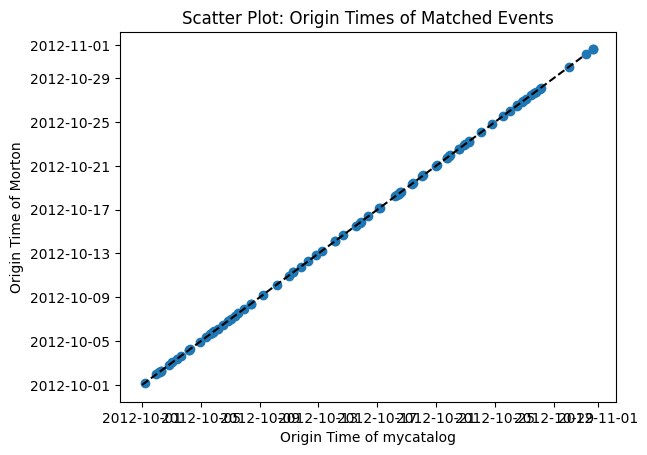

In [26]:
# Make lists for plotting the 1:1 line
x = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton2mycatalog))
y = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton2mycatalog))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog2morton,matched_times_morton2mycatalog)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

## Plot the Latitudes from mycatalog and Morton's catalog

Text(0.5, 1.0, 'Latitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

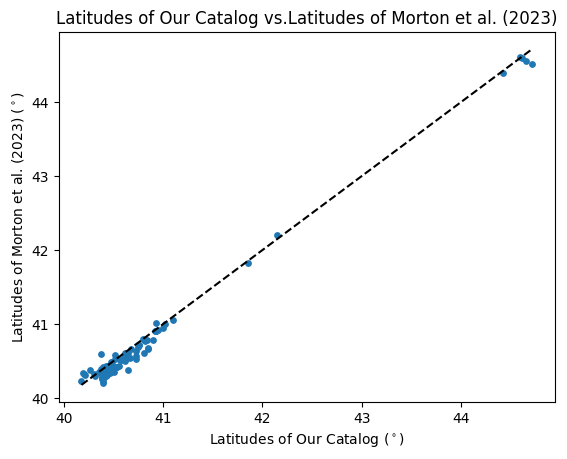

In [23]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog)
lat_max = max(lat_mycatalog)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog,lat_morton, s=15)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of Our Catalog ($^\circ$)')
plt.ylabel('Latitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Latitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Plot the longitudes from mycatalog and Morton's catalog

Text(0.5, 1.0, 'Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

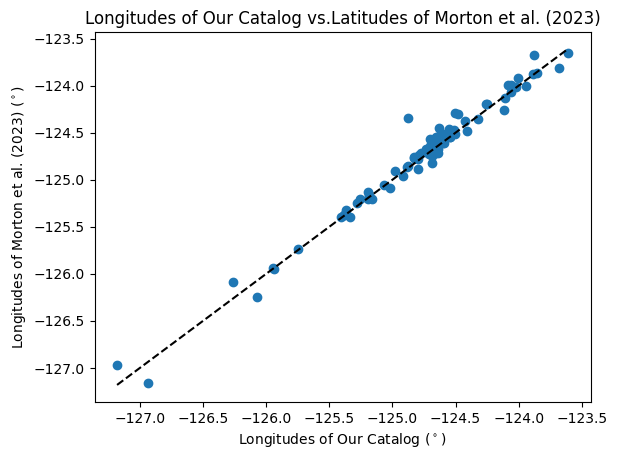

In [24]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog)
lon_max = max(lon_mycatalog)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog,lon_morton)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Histograms
Make histograms of mycatalog vs. Morton's catalog

### Histogram: All of our catalog 

In [27]:
events_october = pd.read_csv('../data/events_201210.csv')

In [28]:
temp_time = matched_events_mycatalog.iloc[1]['time']
temp_time

NameError: name 'matched_events_mycatalog' is not defined

In [29]:
unmatched_events_mycatalog.loc[unmatched_events_mycatalog['time']==temp_time]

NameError: name 'unmatched_events_mycatalog' is not defined

In [ ]:
# Compare between matched_events_mycataloG ADN 

ls_these_events_exist_in_unmatched_events_mycatalog = []
ls_these_events_do_not_exist_in_unmatched_events_mycatalog =[]
for i in range(len(matched_events_mycatalog)):
    temp_time = matched_events_mycatalog.iloc[i]['time']
    temp = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['time'] == temp_time]
    
    if not temp.empty:  # Check if the DataFrame is not empty
        ls_these_events_exist_in_unmatched_events_mycatalog.append(temp_time)
    else:
        ls_these_events_do_not_exist_in_unmatched_events_mycatalog.append(temp_time)

In [ ]:
# Compare between 
ls_these_events_exist_in_unmatched_events_mycatalog = []
ls_these_events_do_not_exist_in_unmatched_events_mycatalog =[]
for i in range(len(matched_events_mycatalog)):
    temp_time = matched_events_mycatalog.iloc[i]['time']
    temp = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['time'] == temp_time]
    
    if not temp.empty:  # Check if the DataFrame is not empty
        ls_these_events_exist_in_unmatched_events_mycatalog.append(temp_time)
    else:
        ls_these_events_do_not_exist_in_unmatched_events_mycatalog.append(temp_time)

In [ ]:
len(ls_these_events_exist_in_unmatched_events_mycatalog)

In [ ]:
len(ls_these_events_do_not_exist_in_unmatched_events_mycatalog)

In [ ]:
# Plot the histogram of the number of picks for all events in events_october.csv
# plt.figure()
# fig,ax = plt.subplots(2,sharex=True)
# bins = np.linspace(5,26,20)
# ax[0].hist(events_october['picks'], bins=bins)

# # ax[0].set_xlabel('Number of Picks')
# ax[0].set_ylabel('Number of Events')
# ax[0].set_title('Histogram of Picks vs. the Number of Events')

# ax[1].hist(matched_events_mycatalog['picks'],bins=bins)
# ax[1].set_xlabel('Number of Picks')
# ax[1].set_ylabel('Number of Events')
# ax[1].set_title('Histogram of Matched Events: Picks vs. the Number of Events')

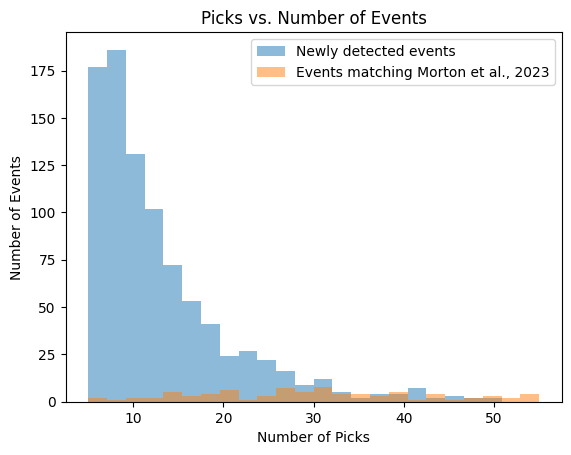

In [33]:
# Plot the same histogram but overlay the histograms
bins = np.linspace(5,55,25)

plt.hist(unmatched_events_mycatalog2morton_and_anss['picks'], bins=bins,  
         alpha=0.5, # the transaparency parameter 
         label='Newly detected events') 
  
plt.hist(matched_events_mycatalog2morton['picks'], bins=bins,
         alpha=0.5, 
         label='Events matching Morton et al., 2023') 
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')  
plt.legend(loc='upper right') 
plt.title('Picks vs. Number of Events') 
plt.show()


### Histogram: Those matched with Morton 

Text(0.5, 1.0, 'Histogram of Matched Events: Picks vs. the Number of Events')

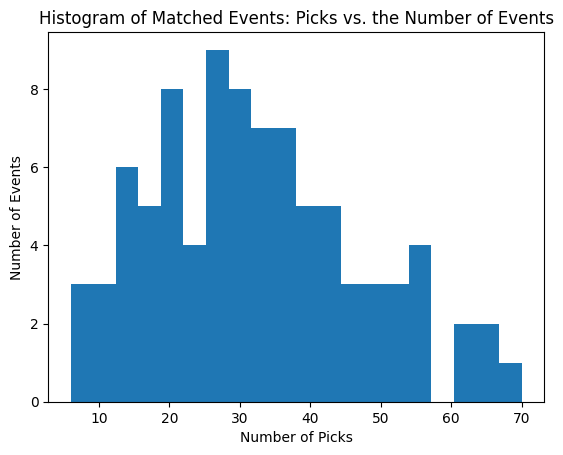

In [36]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
plt.hist(matched_events_mycatalog2morton['picks'],bins=20)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events: Picks vs. the Number of Events')

### Plot the waveforms of the Unmatched events in Morton's catalog

In [37]:
client = WaveformClient()
client2 = Client("IRIS")

In [38]:
df = pd.read_csv('../data/all_picks_all_stations.csv')
df

Unnamed: 0 event_id source_type station_network_code  \
0                0                                        7D   
1                1                                        7D   
2                2                                        7D   
3                3                                        7D   
4                4                                        7D   
...            ...      ...         ...                  ...   
662485         405                                        7D   
662486         406                                        7D   
662487         407                                        7D   
662488           0                                        UW   
662489           1                                        UW   

       station_channel_code station_code  station_location_code  \
0                                   G34B                    NaN   
1                                   G34B                    NaN   
2                                   G34B                    NaN   
3                                   G34B                    NaN   
4                                   G34B                    NaN   
...                     ...          ...                    ...   
662485                             FS18B                    NaN   
662486                             FS18B                    NaN   
662487                             FS18B                    NaN   
662488                              WISH                    NaN   
662489                              WISH                    NaN   

        station_latitude_deg  station_longitude_deg  station_elevation_m  \
0                  42.555401            -125.200996              -2954.0   
1                  42.555401            -125.200996              -2954.0   
2                  42.555401            -125.200996              -2954.0   
3                  42.555401            -125.200996              -2954.0   
4                  42.555401            -125.200996              -2954.0   
...                      ...                    ...                  ...   
662485             40.568199            -124.501602               -107.0   
662486             40.568199            -124.501602               -107.0   
662487             40.568199            -124.501602               -107.0   
662488             47.116980            -123.771180                 45.0   
662489             47.116980            -123.771180                 45.0   

       trace_name  trace_sampling_rate_hz             trace_start_time  \
0                                   125.0  2012-10-05T00:00:00.007900Z   
1                                   125.0  2012-10-05T00:00:00.007900Z   
2                                   125.0  2012-10-05T00:00:00.007900Z   
3                                   125.0  2012-10-05T00:00:00.007900Z   
4                                   125.0  2012-10-05T00:00:00.007900Z   
...           ...                     ...                          ...   
662485                              125.0  2012-10-01T00:00:00.001700Z   
662486                              125.0  2012-10-01T00:00:00.001700Z   
662487                              125.0  2012-10-01T00:00:00.001700Z   
662488                               40.0  2012-10-31T00:00:00.015000Z   
662489                               40.0  2012-10-31T00:00:00.015000Z   

       trace_S_arrival_sample trace_P_arrival_sample trace_S_onset  \
0                                                                    
1                                                                    
2                                                                    
3                                                                    
4                                                                    
...                       ...                    ...           ...   
662485                                                               
662486                                                               
66

In [39]:
_df = df.drop_duplicates(subset='station_code')
_df

Unnamed: 0 event_id source_type station_network_code  \
0                0                                        7D   
221              0                                        7D   
250              0                                        X9   
1509             0                                        7D   
1653             0                                        X9   
...            ...      ...         ...                  ...   
367736           0                                        TA   
379203           0                                        7D   
449578           0                                        7D   
526168           0                                        TA   
592768           0                                        7D   

       station_channel_code station_code  station_location_code  \
0                                   G34B                    NaN   
221                                 J18B                    NaN   
250                                BB060                    NaN   
1509                                G26B                    NaN   
1653                               BB090                    NaN   
...                     ...          ...                    ...   
367736                              L02D                    NaN   
379203                             FS03B                    NaN   
449578                              G18B                    NaN   
526168                              J01D                    NaN   
592768                              M13B                    NaN   

        station_latitude_deg  station_longitude_deg  station_elevation_m  \
0                  42.555401            -125.200996              -2954.0   
221                44.008301            -125.466003              -3047.0   
250                42.856098            -126.113297              -2795.0   
1509               41.924900            -125.177498              -2357.0   
1653               43.373600            -126.660301              -2901.0   
...                      ...                    ...                  ...   
367736             42.157799            -123.603104                458.0   
379203             40.273201            -124.652603               -345.0   
449578             41.301601            -124.936302              -1464.0   
526168             43.161400            -123.931396                131.0   
592768             41.671501            -124.859596               -909.0   

       trace_name  trace_sampling_rate_hz             trace_start_time  \
0                              125.000000  2012-10-05T00:00:00.007900Z   
221                             50.000000  2012-10-09T00:00:00.017058Z   
250                            100.000000  2012-10-09T00:00:00.005000Z   
1509                           124.999992  2012-10-15T00:00:00.002300Z   
1653                           100.000000  2012-10-12T00:00:00.002800Z   
...           ...                     ...                          ...   
367736                         100.000000  2012-10-02T00:00:00.000000Z   
379203                         125.000000  2012-10-14T00:00:00.000300Z   
449578                         125.000008  2012-10-27T01:52:09.723700Z   
526168                          40.000000  2012-10-01T00:00:00.000000Z   
592768                         125.000000  2012-10-19T00:00:00.002900Z   

       trace_S_arrival_sample trace_P_arrival_sample trace_S_onset  \
0                                                                    
221                                                                  
250                                                                  
1509                                                                 
1653                                                                 
...                       ...                    ...           ...   
367736                                                               
379203                                                               
44

In [40]:
networks_stas = np.array(_df[["station_network_code", "station_code" ]])
networks_stas

array([['7D', 'G34B'],
       ['7D', 'J18B'],
       ['X9', 'BB060'],
       ['7D', 'G26B'],
       ['X9', 'BB090'],
       ['7D', 'G04B'],
       ['CN', 'OZB'],
       ['7D', 'G36B2'],
       ['7D', 'G27B'],
       ['7D', 'G03B'],
       ['7D', 'G02B'],
       ['7D', 'G11B'],
       ['X9', 'BB070'],
       ['7D', 'J11B'],
       ['7D', 'G28B'],
       ['7D', 'G35B'],
       ['7D', 'M11B'],
       ['X9', 'BB030'],
       ['7D', 'G19B'],
       ['7D', 'G20B'],
       ['7D', 'J10B'],
       ['7D', 'M09B'],
       ['7D', 'J19B'],
       ['7D', 'J27B'],
       ['7D', 'FS20B'],
       ['7D', 'G10B'],
       ['NV', 'NC89'],
       ['NV', 'NCBC'],
       ['CN', 'BTB'],
       ['7D', 'G33B'],
       ['7D', 'G17B'],
       ['TA', 'G03D'],
       ['7D', 'J25B'],
       ['7D', 'G25B'],
       ['TA', 'I02D'],
       ['7D', 'FS06B'],
       ['UW', 'LRIV'],
       ['NC', 'KMPB'],
       ['NC', 'KMR'],
       ['7D', 'J33B'],
       ['NC', 'KSXB'],
       ['NC', 'KEB'],
       ['7D', 'FS11B'],
       

In [44]:
new_events_lat_44_deg = unmatched_events_mycatalog2morton_and_anss.loc[(unmatched_events_mycatalog2morton_and_anss['latitude']>43.9)&(unmatched_events_mycatalog2morton_and_anss['latitude']<44.1)]
new_events_lat_44_deg

Unnamed: 0  idx                              time           x          y  \
318        5722  365  2012-10-11 16:22:30.302671+00:00  216.157442 -56.243386   
593       10809  687  2012-10-20 23:44:50.176805+00:00 -216.157442 -58.636627   
713       13030  826  2012-10-25 09:08:55.218032+00:00   53.722104 -47.867043   

             z  picks   latitude   longitude      depth  event_idx  pick_idx  \
318  31.640625      7  43.962084 -122.806730  31.640625        365    326713   
593  21.484375     17  43.940569 -128.192298  21.484375        687    140816   
713   0.390625      6  44.067255 -124.829443   0.390625        826     48167   

     residual station phase     time_pick                         datetime  
318 -0.603956     DBO     P  1.349973e+09 2012-10-11 16:22:30.302671+00:00  
593 -0.405047    BABR     P  1.350777e+09 2012-10-20 23:44:50.176805+00:00  
713  1.264100   BB070     P  1.351156e+09 2012-10-25 09:08:55.218032+00:00

In [45]:
unmatched_events_mycatalog2morton_and_anss

Unnamed: 0   idx                              time           x  \
0            21     1  2012-10-01 06:06:25.601846+00:00  104.483147   
1            30     2  2012-10-01 06:49:32.006296+00:00   62.182278   
2            46     3  2012-10-01 06:55:58.805940+00:00   79.102626   
3            56     4  2012-10-01 07:27:43.834659+00:00   74.026521   
4            79     5  2012-10-01 11:20:40.350580+00:00   24.111495   
..          ...   ...                               ...         ...   
898       16286  1034  2012-10-31 21:54:06.462879+00:00   46.107948   
899       16295  1035  2012-10-31 22:15:09.049891+00:00   26.649548   
900       16307  1036  2012-10-31 22:39:33.633187+00:00   37.647774   
901       16318  1037  2012-10-31 23:36:24.517716+00:00  -43.569895   
902       16346  1038  2012-10-31 23:52:20.194822+00:00   48.646000   

              y          z  picks   latitude   longitude      depth  \
0   -425.999093  25.390625      9  40.658485 -124.264521  25.390625   
1   -443.948400  33.984375     16  40.501128 -124.766430  33.984375   
2   -479.847012  27.734375     10  40.176440 -124.571285  27.734375   
3   -458.307844  36.328125     23  40.370857 -124.628388  36.328125   
4   -433.178816  24.609375     13  40.600089 -125.215135  24.609375   
..          ...        ...    ...        ...         ...        ...   
898  540.870200  11.328125      9  49.363533 -124.865233  11.328125   
899 -405.656546  49.609375     12  40.847847 -125.183979  49.609375   
900 -422.409232  44.921875     11  40.696563 -125.054570  44.921875   
901 -442.751779  43.359375     28  40.513089 -126.014090  43.359375   
902 -433.178816  31.640625     10  40.599010 -124.925282  31.640625   

     event_idx  pick_idx  residual station phase     time_pick  \
0            1    554952 -0.426542   FS04B     S  1.349072e+09   
1            2     86563  0.851777   BB030     P  1.349074e+09   
2            3    153785 -0.829479   FS01B     P  1.349075e+09   
3            4    153787 -0.192129   FS01B     P  1.349076e+09   
4            5    153796 -0.832368   FS01B     P  1.349090e+09   
..         ...       ...       ...     ...   ...           ...   
898       1034     64332 -0.319786     BTB     P  1.351720e+09   
899       1035    345220  0.577326   FS09B     P  1.351722e+09   
900       1036    228470  0.676558   FS02B     P  1.351723e+09   
901       1037    152971 -0.129740   FS01B     P  1.351727e+09   
902       1038    152973  1.035059   FS01B     P  1.351728e+09   

                            datetime  
0   2012-10-01 06:06:25.601846+00:00  
1   2012-10-01 06:49:32.006296+00:00  
2   2012-10-01 06:55:58.805940+00:00  
3   2012-10-01 07:27:43.834659+00:00  
4   2012-10-01 11:20:40.350580+00:00  
..                               ...  
898 2012-10-31 21:54:06.462879+00:00  
899 2012-10-31 22:15:09.049891+00:00  
900 2012-10-31 22:39:33.633187+00:00  
901 2012-10-31 23:36:24.517716+00:00  
902 2012-10-31 23:52:20.194822+00:00  

[903 rows x 17 columns]

Failed to fetch for TA L02E 2012-10-03T03:25:15.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to fetch for TA J01E 2012-10-03T03:25:15.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/core/trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)


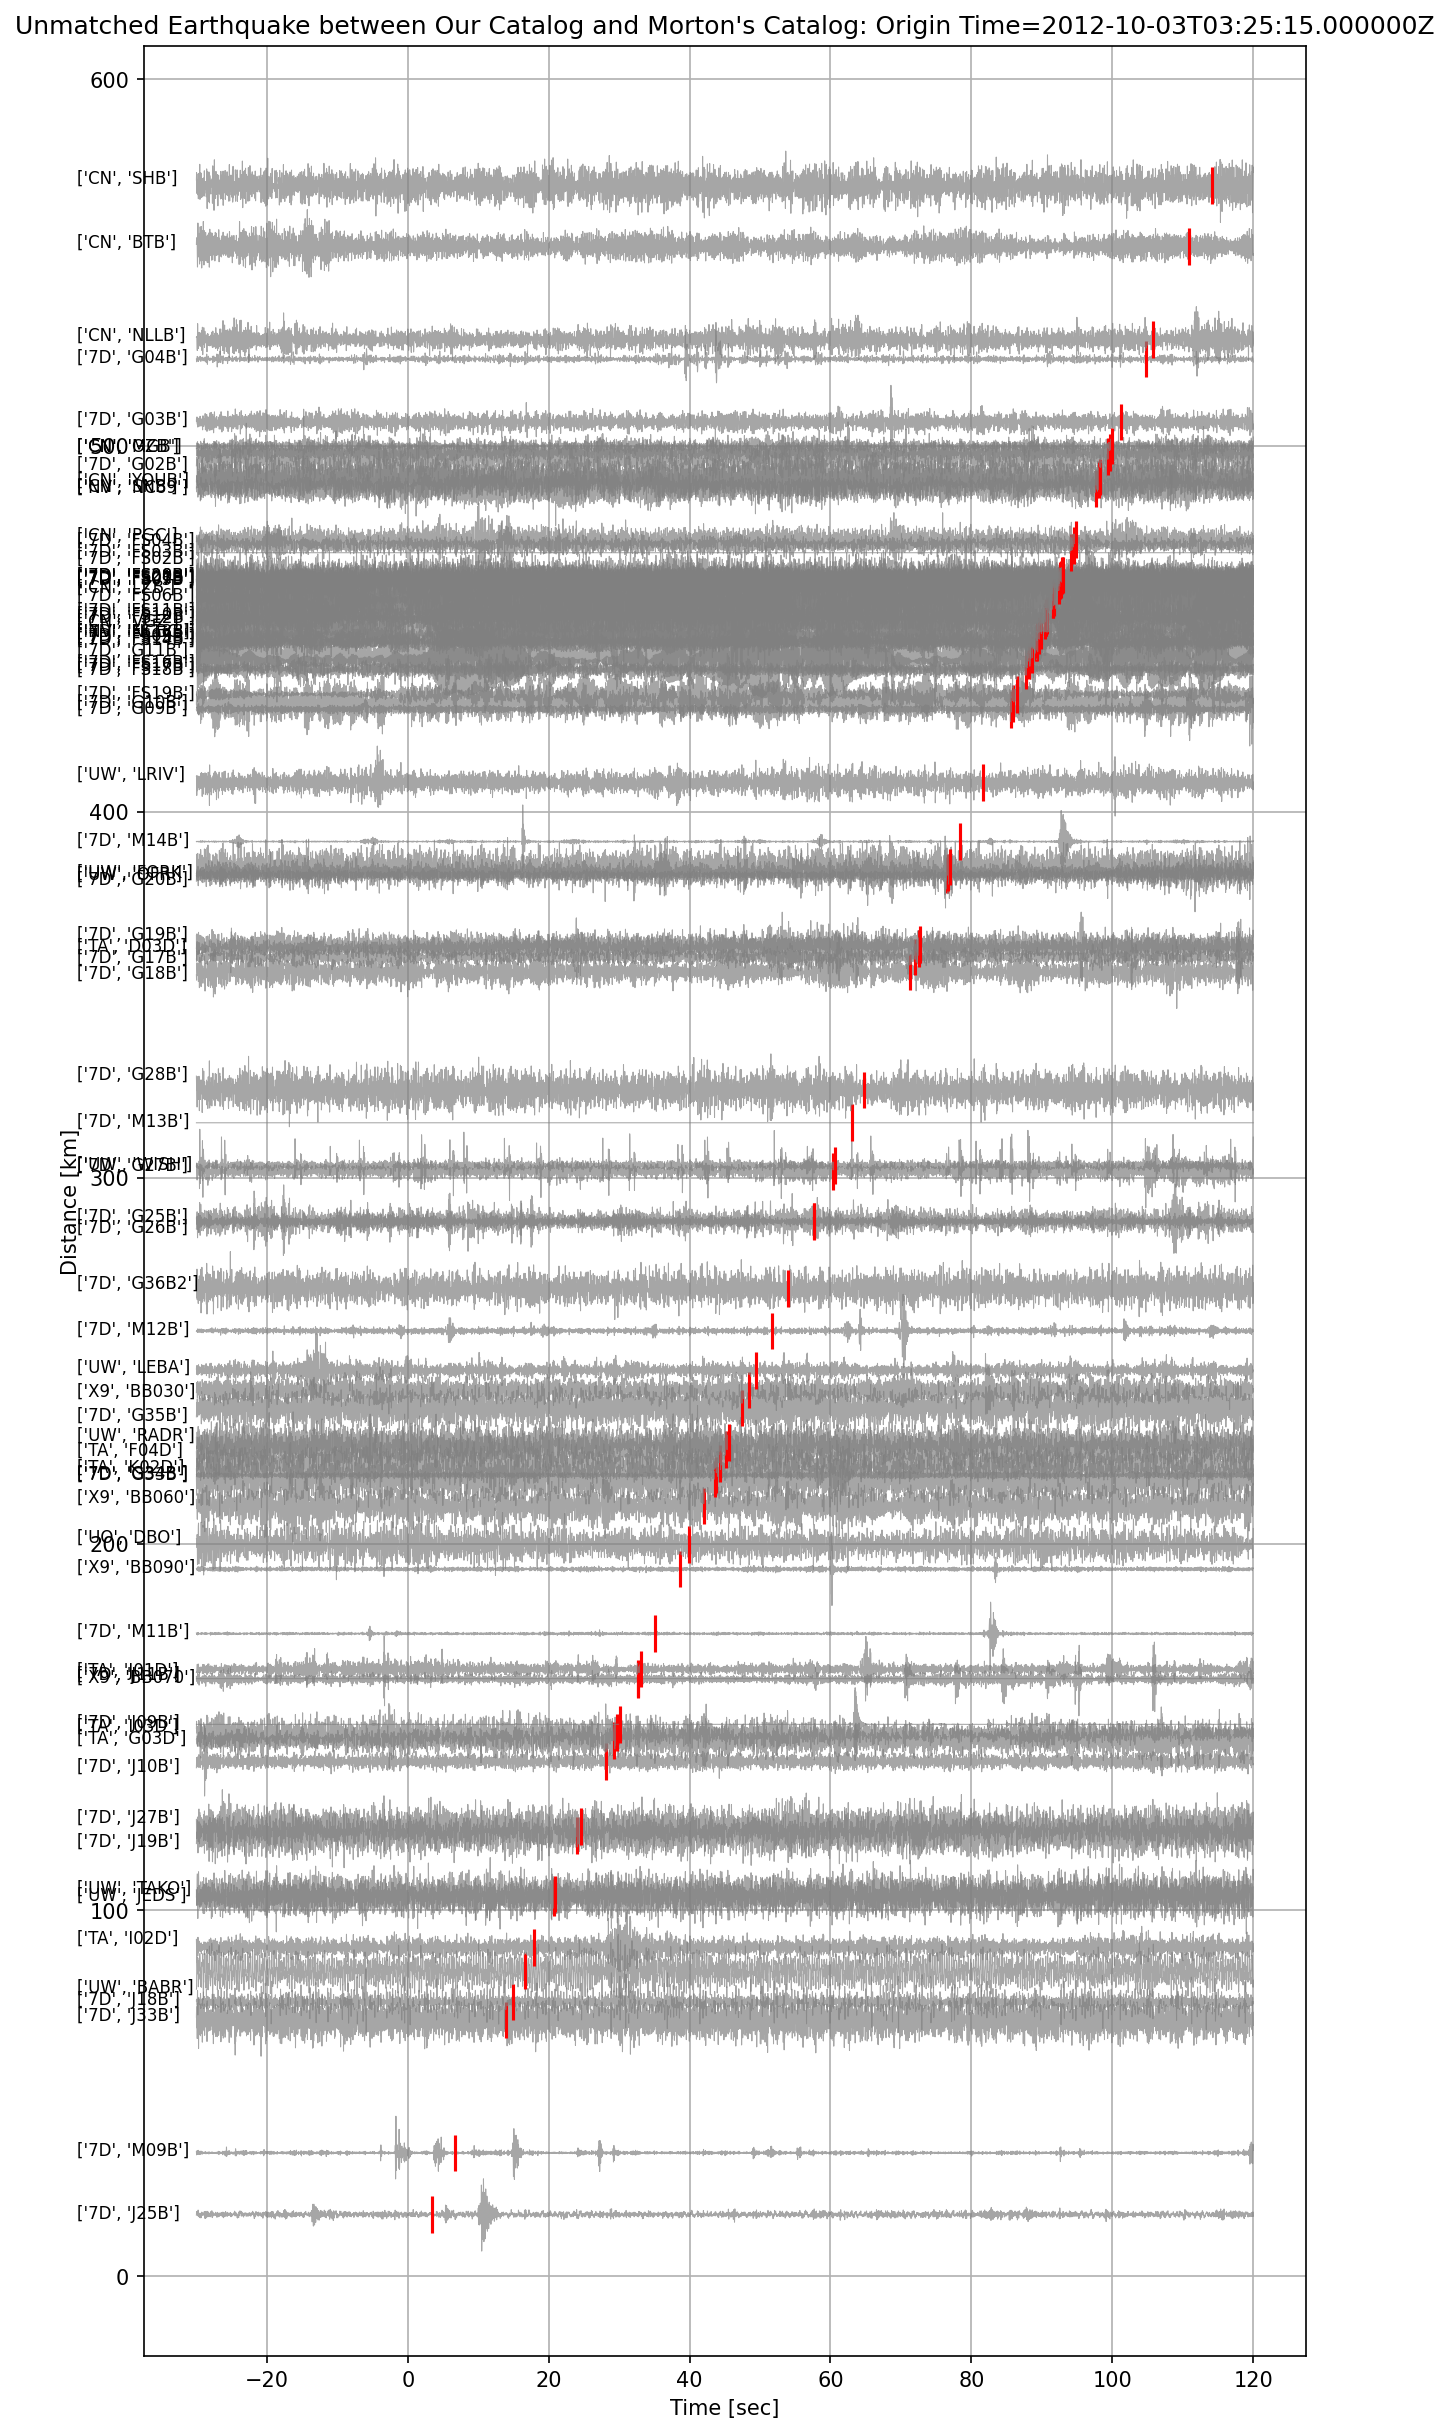

In [47]:
# Plot the earthquake moveout for one of the unmatched events

idx = 0
event = unmatched_events_morton2mycatalog.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['LAT']
    olon = event['LON']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog: Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

Failed to fetch for TA L02E 2012-10-03T03:25:15.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to fetch for TA J01E 2012-10-03T03:25:15.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/core/trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)


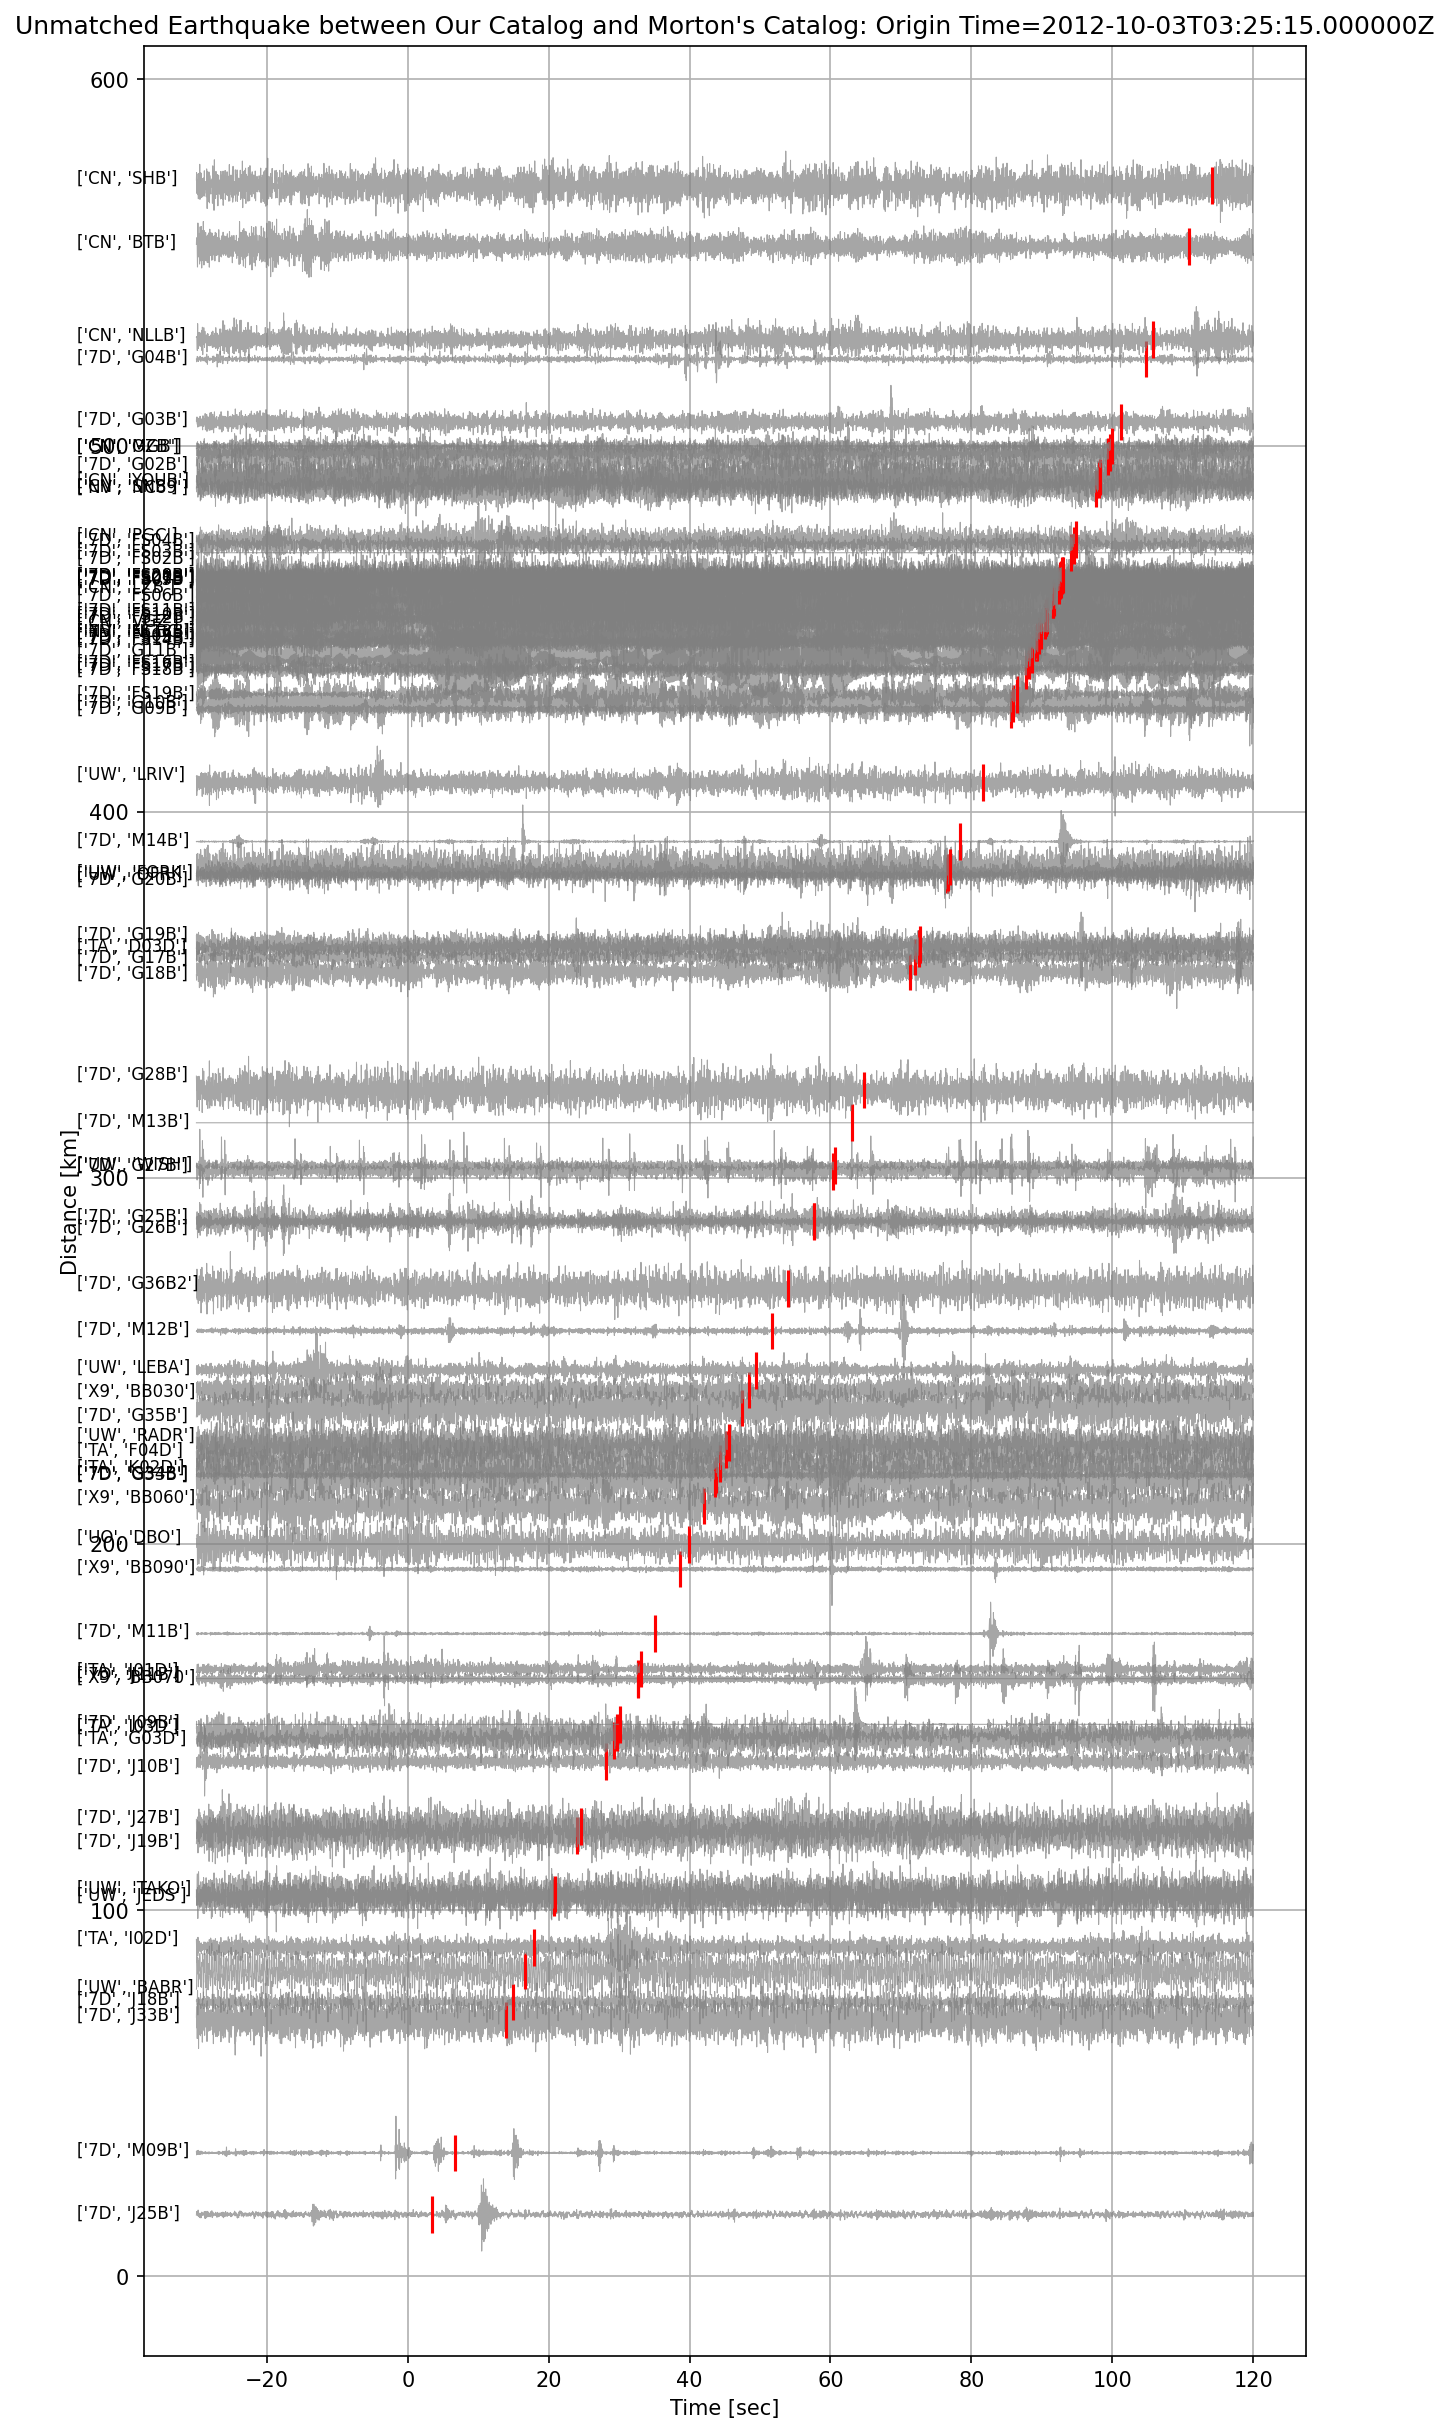

Failed to fetch for TA L02E 2012-10-04T04:51:41.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to fetch for TA J01E 2012-10-04T04:51:41.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to fetch for TA J01D 2012-10-04T04:51:41.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/core/trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)


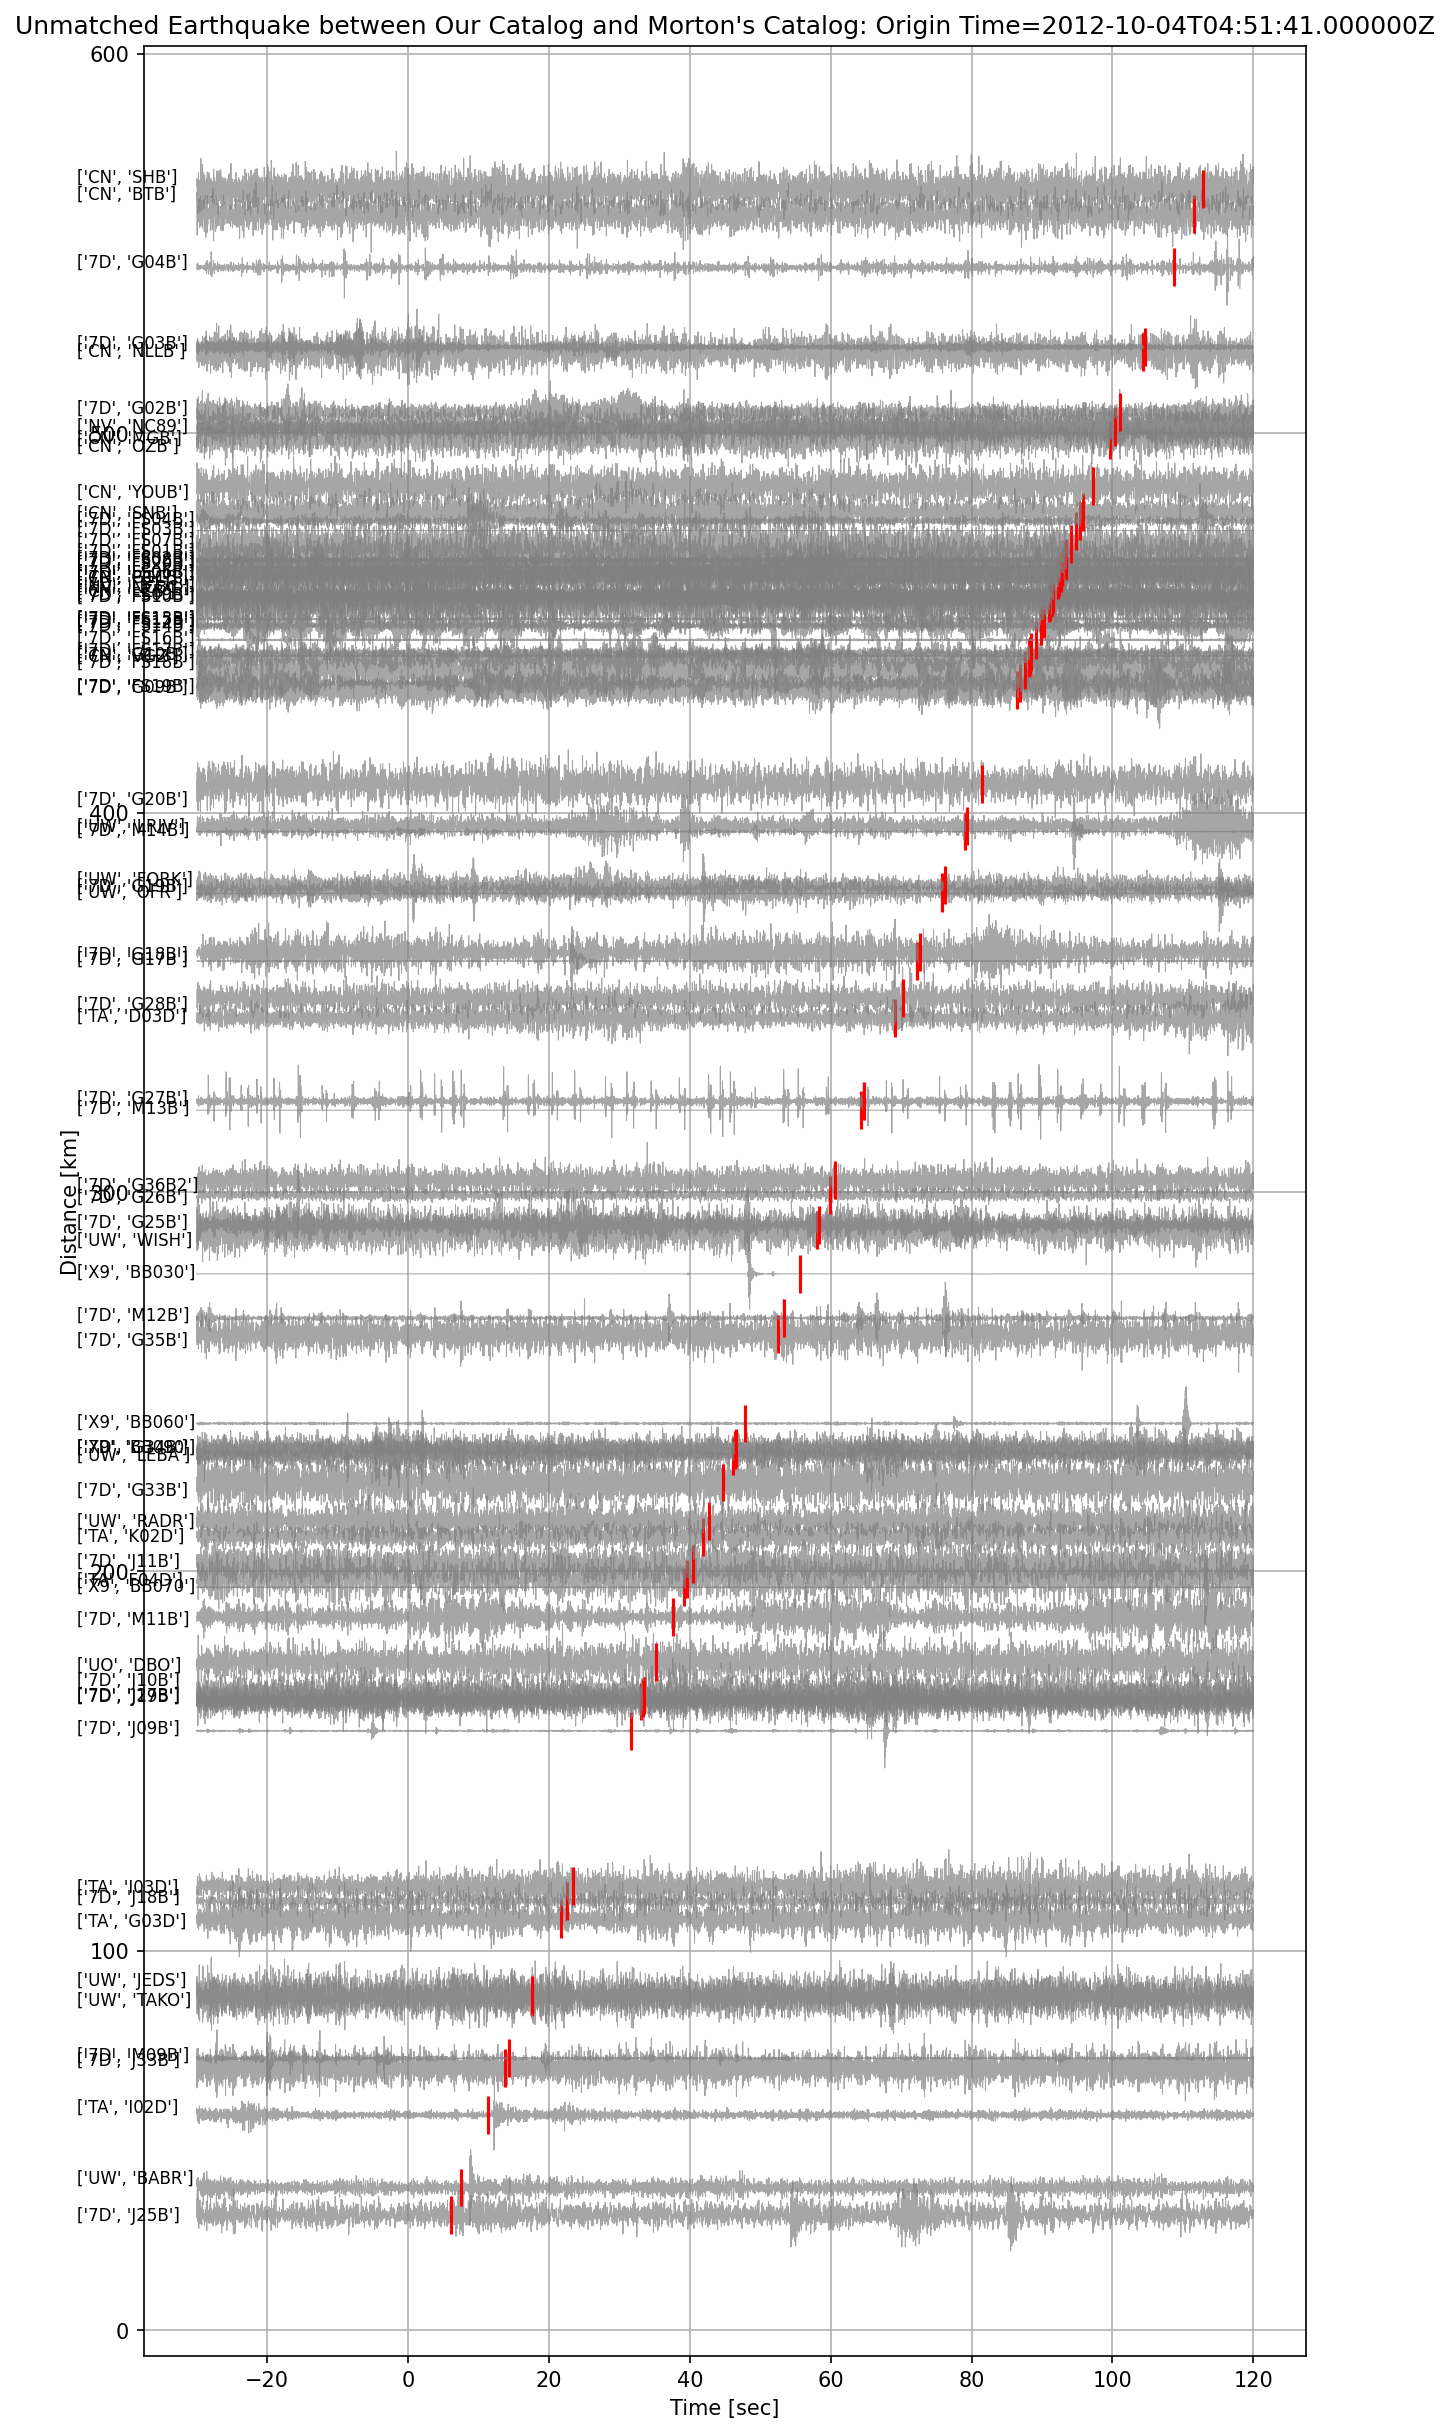

Failed to fetch for TA L02E 2012-10-04T05:34:57.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to fetch for TA J01E 2012-10-04T05:34:57.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to fetch for TA J01D 2012-10-04T05:34:57.000000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/core/trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)


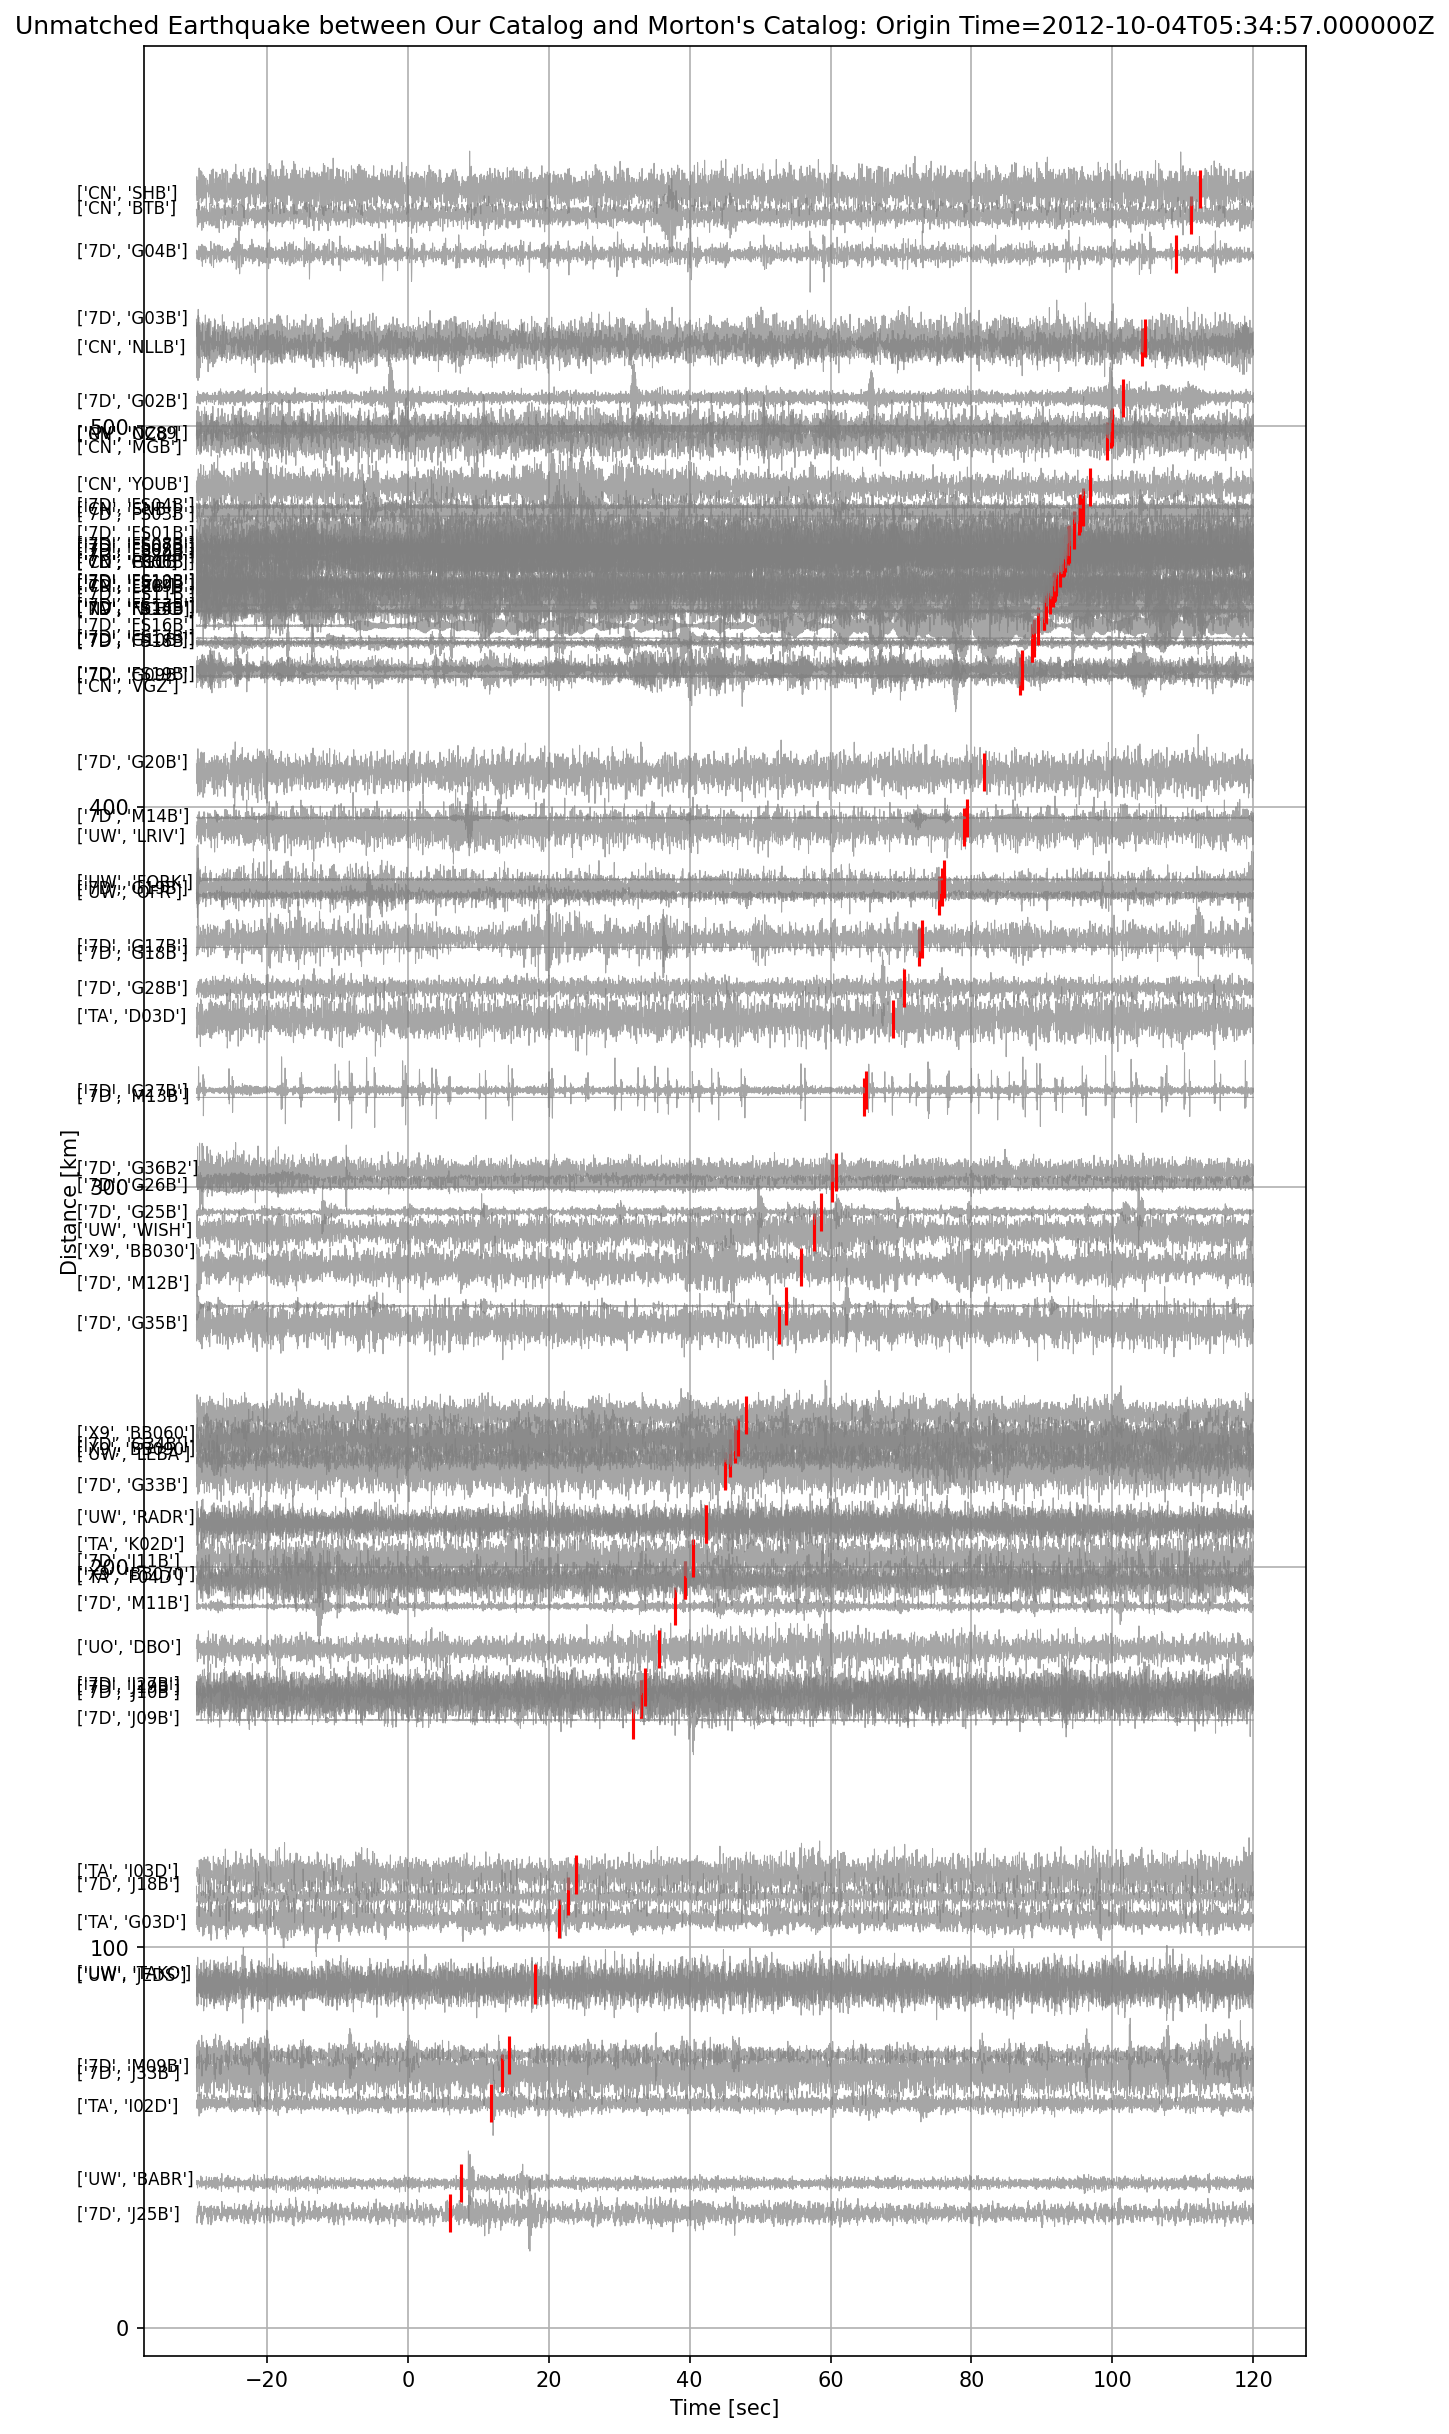

In [50]:
# Plot the earthquake moveouts for the unmatched events for Morton's catalog
for idx in range(len(unmatched_events_morton2mycatalog)):
    event = unmatched_events_morton2mycatalog.iloc[idx]
    otime = UTCDateTime(event['datetime'])
    distances = []

    # Assuming networks_stas is a list of tuples with network and station identifiers
    for network, station in networks_stas:
        try:
            sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                           starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
        except Exception as e:
            print(f"Failed to fetch for {network} {station} {otime}: {e}")
            continue

        slat = sta_inv.latitude
        slon = sta_inv.longitude
        olat = event['LAT']
        olon = event['LON']

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
        distances.append([network,station,dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    # print(distances)
    # print(otime)
    plt.figure(figsize=(10,20), dpi=150)
    for i, ii in enumerate(distances):
        st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
        st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
        st.filter(type='bandpass',freqmin=4,freqmax=15)

        trim_st = st.copy().trim(starttime = otime - 30, 
                    endtime = otime + 120)
        if len(trim_st)>0:
            trim_st = trim_st.normalize()
            offsets1  = ii[2]
            offsets2 = 0
    #         for ii in range(len(trim_st)):
            plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                     color = 'gray', alpha=0.7, lw=0.5)    
    #         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
    #                      if x['station'] == sta]
    #         if len(time_pick) > 0:
    #             for p in time_pick:
    #                 if p[1] == 'P':
            plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                         [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')

            plt.vlines(ii[2]/5, offsets1-5, 
                             offsets1+5, color='r')
    #                 else:
    #                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
    #                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
        else:                 
            pass 
    plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog: Origin Time={otime}")
    plt.xlabel('Time [sec]')
    plt.ylabel('Distance [km]')
    plt.grid()


    plt.show()

### Plot the waveforms of the unmatched events in our catalog (newly found events at the Mendocino Junction)

In [53]:
new_event_example_picks = mycatalog_picks.loc[mycatalog_picks['event_idx']==1037]
pick_sta = np.unique(new_event_example_picks['station'])
pick_sta

array(['FS01B', 'FS02B', 'FS04B', 'FS06B', 'FS09B', 'FS13B', 'FS16B',
       'FS20B', 'G02B', 'G03B', 'G10B', 'G11B', 'G19B', 'G20B', 'G26B',
       'JCC', 'K02D', 'M12B'], dtype=object)

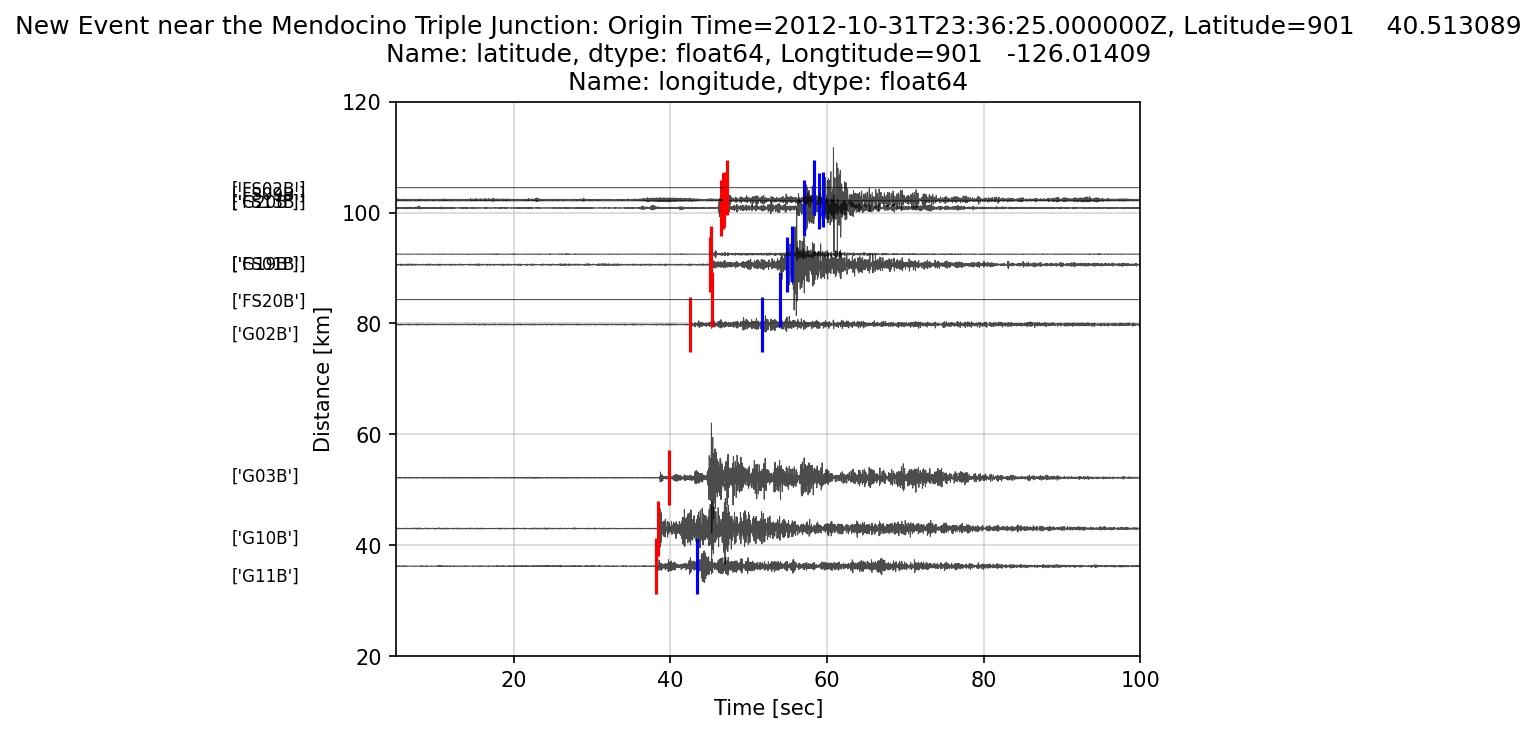

In [54]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=temp_event
# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(2012,10,31,23,36,25)
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -16, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"New Event near the Mendocino Triple Junction: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(20,120)
plt.xlim(5,100)

plt.grid(alpha=0.5)

plt.savefig("event_idx_1037.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
otime,trim_st[0].times()

In [ ]:
distances

### Plot the waveforms of the unmatched events in our catalog (newly found events offshore WA and OR)

In [ ]:
unmatched_events_mycatalog[(unmatched_events_mycatalog['picks']>0) & (unmatched_events_mycatalog['latitude']>45) & (unmatched_events_mycatalog['latitude']<48)&(unmatched_events_mycatalog['longitude']>-127) & (unmatched_events_mycatalog['longitude']<-124.5)]

In [ ]:
event_WA_OR = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['idx']==49].iloc[0]
event_WA_OR

In [ ]:
new_event_example_picks_WA_OR = mycatalog_picks.loc[mycatalog_picks['idx']==event_WA_OR['idx']]
new_event_example_picks_WA_OR

In [ ]:
pick_sta_WA_OR=np.unique(new_event_example_picks_WA_OR['station'])
pick_sta_WA_OR

In [ ]:

# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_WA_OR
new_event_example_picks = new_event_example_picks_WA_OR
pick_sta = pick_sta_WA_OR

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event_WA_OR['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"New Event Offshore WA and OR: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(20,120)
plt.xlim(20,140)

plt.grid(alpha=0.5)

plt.savefig("event_idx_49.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Plot the waveforms of the unmatched events in our catalog (newly found events offshore WA and OR) #2

In [ ]:
event_WA_OR_idx_424 = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['idx']==424].iloc[0]
event_WA_OR_idx_424

In [ ]:
new_event_example_picks_WA_OR_idx_424 = mycatalog_picks.loc[mycatalog_picks['event_idx']==event_WA_OR_idx_424['idx']]
new_event_example_picks_WA_OR_idx_424

In [ ]:
pick_sta_WA_OR_idx_424=np.unique(new_event_example_picks_WA_OR_idx_424['station'])
pick_sta_WA_OR_idx_424

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_WA_OR_idx_424
new_event_example_picks = new_event_example_picks_WA_OR_idx_424
pick_sta = pick_sta_WA_OR_idx_424

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
#         wave=trim_st[0].data
#         wave=wave/np.std(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Newly Found Events: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(20,120)
plt.xlim(20,140)

plt.grid(alpha=0.5)

plt.savefig("event_idx_424.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Plot the waveforms of the unmatched events in our catalog (Near the seamount)

In [ ]:
unmatched_events_mycatalog2morton_and_anss

In [ ]:
abc=unmatched_events_mycatalog2morton_and_anss[(unmatched_events_mycatalog2morton_and_anss['longitude']<-126)]
abc.sort_values(by=['picks'])

In [ ]:
event_seamount = unmatched_events_mycatalog2morton_and_anss.loc[unmatched_events_mycatalog2morton_and_anss['idx']==274].iloc[0]
event_seamount

In [ ]:
new_event_example_picks_seamount_idx_926 = mycatalog_picks.loc[mycatalog_picks['event_idx']==event_seamount['idx']]
new_event_example_picks_seamount_idx_926

In [ ]:
pick_sta_seamount_idx_926=np.unique(new_event_example_picks_seamount_idx_926['station'])
pick_sta_seamount_idx_926

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_seamount
new_event_example_picks = new_event_example_picks_seamount_idx_926
pick_sta = pick_sta_seamount_idx_926

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        wave=trim_st[0].data
        wave=wave/np.nanmax(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),wave *10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Newly Found Events: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(0,200)
plt.xlim(20,100)

plt.grid(alpha=0.5)

plt.savefig("event_idx_274.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Plot the earthquake moveout for one of the unmatched events for all stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
event = unmatched_events_mycatalog.iloc[idx]
otime = UTCDateTime(new_event_example['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# distances = distances[0:4]
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(80,120)
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
event = unmatched_events_mycatalog.iloc[idx]
otime = UTCDateTime(new_event_example['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:8]
# print(distances)
# print(otime)
plt.figure()
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(80,120)
plt.grid()


plt.show()

## Plot the earthquake moveout for one of the unmatched events for some stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events
idx = 0
event = unmatched_events_mycatalog.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveouts for the unmatched events for our catalog

ls_idx = np.arange(0,30) # Choose the indices of the events to plot
for idx in ls_idx:
    # Plot the earthquake moveout for one of the unmatched events

    event = unmatched_events_mycatalog.iloc[idx]
    otime = UTCDateTime(event['datetime'])
    distances = []

    # Assuming networks_stas is a list of tuples with network and station identifiers
    for network, station in networks_stas:
        try:
            sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                           starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
        except Exception as e:
            print(f"Failed to fetch for {network} {station} {otime}: {e}")
            continue

        slat = sta_inv.latitude
        slon = sta_inv.longitude
        olat = event['latitude']
        olon = event['longitude']

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
        distances.append([network,station,dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    # print(distances)
    # print(otime)
    plt.figure(figsize=(10,20), dpi=150)
    for i, ii in enumerate(distances):
        st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
        st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
        st.filter(type='bandpass',freqmin=4,freqmax=15)

        trim_st = st.copy().trim(starttime = otime - 30, 
                    endtime = otime + 120)
        if len(trim_st)>0:
            trim_st = trim_st.normalize()
            offsets1  = ii[2]
            offsets2 = 0
    #         for ii in range(len(trim_st)):
            plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                     color = 'gray', alpha=0.7, lw=0.5)    
    #         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
    #                      if x['station'] == sta]
    #         if len(time_pick) > 0:
    #             for p in time_pick:
    #                 if p[1] == 'P':
            plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                         [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')

            plt.vlines(ii[2]/5, offsets1-5, 
                             offsets1+5, color='r')
    #                 else:
    #                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
    #                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
        else:                 
            pass 
    plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
    plt.xlabel('Time [sec]')
    plt.ylabel('Distance [km]')
    plt.grid()


    plt.show()

## Plot the earthquake moveout for one of the matched events for all stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events
idx = 0
event = matched_events_mycatalog.iloc[idx]
otime = UTCDateTime(event['datetime'])
picks = 
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()